# What Statistics Actually Matter for PPR Fantasy Football
We want to analyze the cleaned data from out SQL database to see if we can determine what stats outside of the built-in PPR scoring stats can be used to predict if a player will finish within top 12/24 of their position. For Quarterbacks and Tight Ends, we will be focusing on the top 12 and for Running Backs and Wide Receivers, we will focus on the top 24. This is because in many leagues it standard to start 1 Quarterback, 2 Running Backs, 2 Wide Receivers, and 1 Tight End. We can split of the rankings as follows, assuming a  12-man league:

- Top 12 Ranked QB -> QB1
- Top 12 Ranked RB -> RB1
- Ranked 24-12 RB -> RB2
- Top 12 Ranked WR -> WR1
- Ranked 24-12 WR -> WR2
- Top 12 Ranked TE -> TE1

One thing to keep in mind with these statistics is that they assume that the players are in similar situations as the prior year, which is simply not true. Some players move to different teams, teams get new coaches, rookies can take starting spots, etc. None of these changes can be captured within game statistics, so it's up to the person drafting to understand real world context while looking through the analysis.


In [1]:
# IMPORT PACKAGES
import pandas as pd
import sqlalchemy as sa
import pymysql
import os
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cryptography
from sklearn.linear_model import LinearRegression

## Prepartion for Analysis

In [2]:
# Connect to the Fanatsy database
# DEFINE THE DATABASE CREDENTIALS
user = 'root'
password = 'password123'
host = 'localhost'
port = 3306
database = 'fantasydb'

# PYTHON FUNCTION TO CONNECT TO THE MYSQL DATABASE AND
# RETURN THE SQLACHEMY ENGINE OBJECT
def get_connection():
	return create_engine(
		url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
			user, password, host, port, database
		)
	)

try:
    # GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
    engine = get_connection()
    print(
        f"Connection to the {host} for user {user} created successfully.")
except Exception as ex:
    print("Connection could not be made due to the following error: \n", ex)


Connection to the localhost for user root created successfully.


## Functions for our Analysis
We want to identify the attributes that correlate to total fantasy points in a season. To do so, we will retrieve data from each of the last 5 years and create a dataframe consisting only of their game statistics. We will then use the new dataframe to create a correlation matrix. After, we will look at the correlation coefficients of each attribute to fantasy points and look for stats that stand out. 

In [3]:
# RETRIEVE ALL PLAYERS OF A POSITION FROM A GIVEN YEAR FROM OUR SQL DATABASE
def retrieve_players(pos, year):
    with engine.begin() as conn:
        df = pd.read_sql_query(sa.text(
            f'''
            SELECT 
                *
            FROM 
                {pos}_stats_{year}
            '''), conn)
        conn.close()
    return df

In [4]:
# RETURN THE TOP X PLAYERS OF A POSITION FROM A SPECIFIC YEAR
def top_x_players(pos, year, rank,):
    with engine.begin() as conn:
        df = pd.read_sql_query(sa.text(
            f'''
            SELECT
                *
            FROM 
                {pos}_stats_{year}
            WHERE
                {pos}_stats_{year}.RANK <= {rank}
            '''), conn)
        conn.close()
    return df

In [5]:
# FUNCTION TO RETURN THE TOP X PLAYERS OF A POSITION FROM A SPECIFIC YEAR BASED ON RANKING OF A SPECIFIC ATTRIBUTE
def top_x_players_col(pos,year, rank, col):
    with engine.begin() as conn:
        df = pd.read_sql_query(sa.text(
            f'''
            SELECT 
                *
            FROM 
                {pos}_stats_{year}
            ORDER BY 
                {col} DESC
            LIMIT {rank}
            '''), conn)
        conn.close()
    return df

In [6]:
# FUNCTION TO GET ALL DATA FROM GIVEN POSITION FOR CORRELATION MATRIX
def last_five(years, pos):
    df = retrieve_players(pos,years[0])
    for y in years[1:]:
        tmp_df = retrieve_players(pos,y)
        df = pd.concat([df, tmp_df], ignore_index = True)
    
    df = df.drop(columns=['index', 'RANK', 'NAME', 'G'])
    return df

In [7]:
# CREATE CORRELATION MATRIX
def correlation_matrix(df, pos):
    plt.figure(figsize=(25,10))
    sns.set_theme(style="dark")
    corr = df.corr()
    plt.title('2018-2023 '+pos+'s Correlation Matrix', loc='center', color='black', size=30)
    heatmap = sns.heatmap(corr, annot=True, cmap="gist_heat", fmt='.2g')    

In [8]:
# CREATE LINEAR REGRESSION/SCATTER PLOT DATA AND PLOT FIGURE
def linear_regression(x,y, title, x_label, y_label):
    
    X = x.values.reshape(-1, 1)  # values converts it into a numpy array
    Y = y.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.scatter(X, Y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(X, Y_pred, color='red')
    plt.show


In [9]:
# Get data from each posotion from the last five years an place into seperate dataframes
years = ['2018', '2019', '2020', '2021', '2022']
qbs_df = last_five(years, 'qb')
rbs_df = last_five(years, 'rb')
wrs_df = last_five(years, 'wr')
tes_df = last_five(years, 'te')

## Something to Note about the Stats
When looking at these correlation matrices, it's important to note that some stats are built into the PPR league scoring, which means they will have a high correlation to fantasy points. Statisitcs such as passing yards, recieving yards, rushing yards, receptions, and touchdowns are already built into PPR league scoring. While looking for players that perform well in those stats is helpful they will not give us an edge in deciding who to look into. For this, we will look at the statistics with a correlation coefficient of 0.75 or higher, and then look at the statistics not built into PPR scoring formats

# Quarterback Analysis

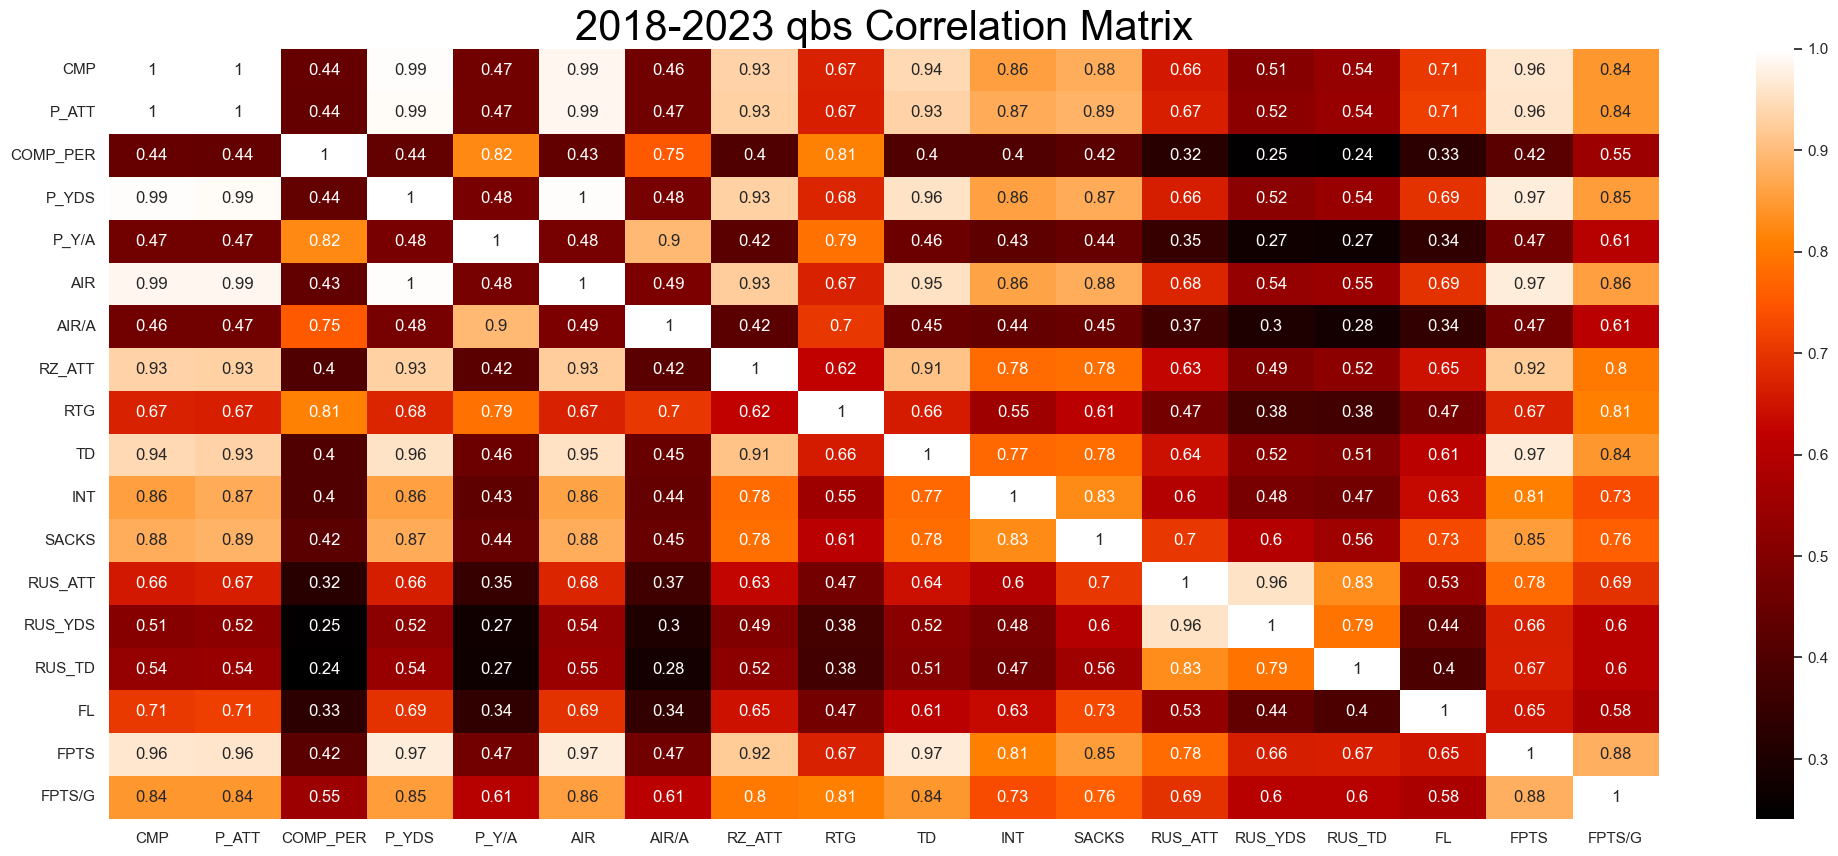

In [10]:
qb_corr = correlation_matrix(qbs_df, 'qb')
qb_corr

## QB Stats Correlations
Quarterback Stats with an Over 0.75 Correlation Coefficient:
- Completion Percentage - 0.96
- Pass Attempts - 0.96
- Pass Yards - 0.97
- Air Yards - 0.97
- Redzone Attempts - 0.92
- Touchdowns - 0.97
- Interceptions - 0.81
- Sacks - 0.85
- Rush Attempts - 0.78

Stats that Stand Out:
- **Rushing Attempts (0.78)**
- **Redzone Attempts (0.92)**

What is interesting is the positive correlation Sacks and Interceptions has with fantasy points, but it makes sense becausee to throw interceptions or get sacked means you are on the field playing, and to score fantasy points you need to be playing. Completion Percentage, Pass Attempts, Air Yards also makes sense since its highly correlated with Passing Yards, which are built into PPR scoring. We want QBs who can throw the ball a lot, accurately. The stats that stand out here though are Redzone Attempts and Rushing Attempts.
 
**RUSHING ATTEMPTS (0.78)**:
- More Rushing Attempts implys a more mobile, dual-threat type Quarterback, which allows them to score fantasy points using their legs.

**REDZONE ATTEMPTS (0.92)**:
- Redzone Attempts is highly correlated with Touchdowns, which makes sense. More Redzone Attempts means you're on a better offense with more scoring opportunity. 

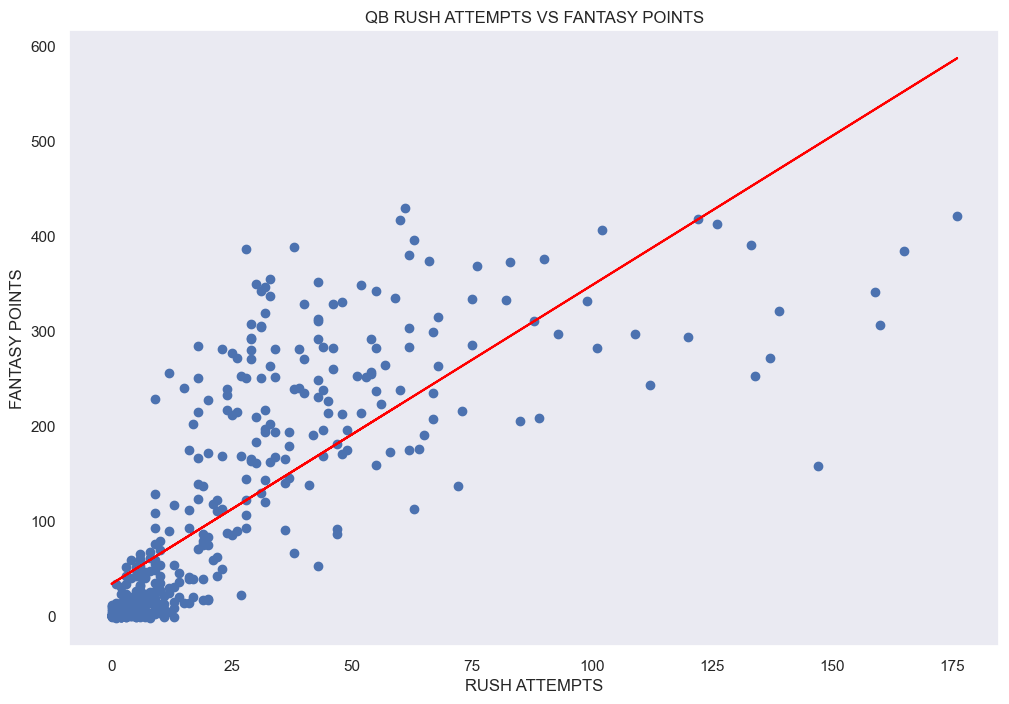

In [11]:
# RUSH ATTEMPTS VS FANTASY POINTS 
x = qbs_df['RUS_ATT']
y = qbs_df['FPTS']
title = 'QB RUSH ATTEMPTS VS FANTASY POINTS'
x_label = 'RUSH ATTEMPTS'
y_label = 'FANTASY POINTS'
qb_lin_1 = linear_regression(x,y, title, x_label, y_label)
qb_lin_1

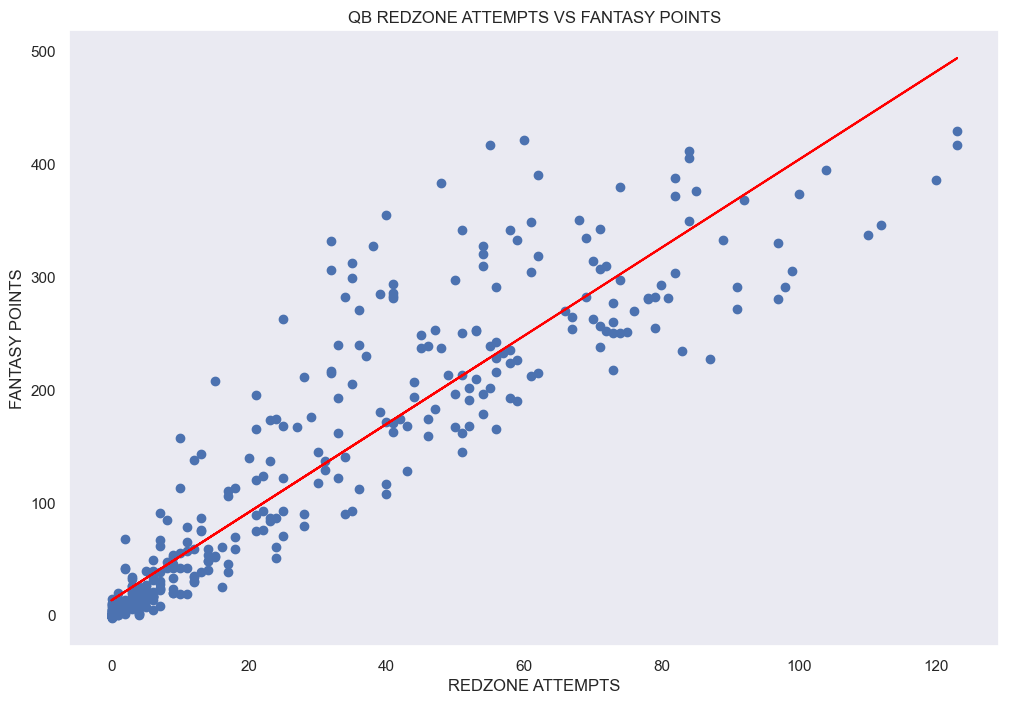

In [12]:
# REDZONE ATTEMPTS VS FANTASY POINTS
x = qbs_df['RZ_ATT']
y = qbs_df['FPTS']
title = 'QB REDZONE ATTEMPTS VS FANTASY POINTS'
x_label = 'REDZONE ATTEMPTS'
y_label = 'FANTASY POINTS'
qb_lin_2 = linear_regression(x,y, title, x_label, y_label)
qb_lin_2

## Important Note About Taking the Top Ranked Players

While we are looking for top 12 QBs (QB1 range), we want to give a little bit of tolarance for some QBs who may be on the fringe of QB1 range. So we will be looking at the top 15 ranked in both statistics. We will follow a similar pattern for our analysis of the Running backs, Wide Receivers, and Tight Ends data

## Observing the QB Data
We now will look at the QBs who were top 15 in both stats to see how they performed overall the following year

In [13]:
# RETREIVE THE STATISTICS OF ALL TOP RANKED PLAYERS IN CONCATENATE THEM INTO A SINGLE DATAFRAME
def comp_all_stats(pos, year, stats, rank):
    # Create an inital dataframe with first stat and merge with the data from following year
    df1 = top_x_players_col(pos, year, rank, stats[0])
    df2 = top_x_players(pos, str(int(year)+1), rank)
    df3 = df1.merge(df2, on='NAME')
    
    # Clean up merged dataframe
    df0 = df3.rename(columns={'RANK_x' : year+'_RANK', stats[0]+'_x': year+'_' + stats[0],
                              'RANK_y': str(int(year)+1) +'_RANK', stats[0] +'_y': str(int(year)+1)+'_' + stats[0],
                              'FPTS_x': year+'_FPTS', 'FPTS_y': str(int(year)+1)+'_FPTS'})
    
    # Keep only the important statistics
    df0 = df0[['NAME', 
               year+'_RANK', str(int(year)+1) +'_RANK', 
               year+'_FPTS', str(int(year)+1)+'_FPTS',
               year+'_' + stats[0], str(int(year)+1)+'_' + stats[0]
               ]]

    # Create dataframess for other stats and merge with the initial dataframe
    for stat in stats[1:]:
        df1 = top_x_players_col(pos, year, rank, stat)
        df2 = top_x_players(pos, str(int(year)+1), rank)
        df3 = df1.merge(df2, on='NAME')
        df3 = df3.rename(
                columns={'RANK_x' : year+'_RANK', stat+'_x': year+'_' + stat,
                        'RANK_y': str(int(year)+1) +'_RANK', stat +'_y': str(int(year)+1)+'_' + stat,
                        'FPTS_x': year+'_FPTS', 'FPTS_y': str(int(year)+1)+'_FPTS'})
        
        df3=df3[['NAME', 
                 year + '_RANK', str(int(year)+1) +'_RANK', 
                 year + '_FPTS', str(int(year)+1)+'_FPTS',
                 year + '_'+ stat, str(int(year)+1)+'_' + stat
                 ]]
        
        df0 = df0.merge(df3, on=['NAME', 
                                 year+'_RANK',str(int(year)+1) +'_RANK', 
                                 year+'_FPTS', str(int(year)+1)+'_FPTS'] )
        
    df0['CHANGE'] = df0[year+'_RANK']-df0[str(int(year)+1)+'_RANK']
    df0['IMPROVE'] =  df0['CHANGE'] >= 0
    
    return df0


In [14]:
# INIT
qb_stats = ['RZ_ATT', 'RUS_ATT']
rank = '15'
# Get dataframes
qbs_2018 = comp_all_stats('qb', '2018', qb_stats, rank)
qbs_2019 = comp_all_stats('qb', '2019', qb_stats, rank)
qbs_2020 = comp_all_stats('qb', '2020', qb_stats, rank)
qbs_2021 = comp_all_stats('qb', '2021', qb_stats, rank)


In [15]:
qbs_2018

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_RZ_ATT,2019_RZ_ATT,2018_RUS_ATT,2019_RUS_ATT,CHANGE,IMPROVE
0,Patrick Mahomes II,1.0,8.0,417.0,291.9,55.0,56.0,60.0,43.0,-7.0,False
1,Dak Prescott,10.0,2.0,285.8,348.9,41.0,61.0,75.0,52.0,8.0,True
2,Aaron Rodgers,6.0,10.0,312.5,282.0,35.0,78.0,43.0,46.0,-4.0,False
3,Russell Wilson,9.0,4.0,299.4,333.5,35.0,89.0,67.0,75.0,5.0,True


In [16]:
qbs_2018.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_RZ_ATT,2019_RZ_ATT,2018_RUS_ATT,2019_RUS_ATT,CHANGE
count,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,6.500000,6.000000,328.675000,314.07500,41.500000,71.000000,61.250000,54.000000,0.500000
std,4.041452,3.651484,59.883853,32.20066,9.433981,15.253415,13.622897,14.491377,7.141428
min,1.000000,2.000000,285.800000,282.00000,35.000000,56.000000,43.000000,43.000000,-7.000000
25%,4.750000,3.500000,296.000000,289.42500,35.000000,59.750000,55.750000,45.250000,-4.750000
50%,7.500000,6.000000,305.950000,312.70000,38.000000,69.500000,63.500000,49.000000,0.500000
75%,9.250000,8.500000,338.625000,337.35000,44.500000,80.750000,69.000000,57.750000,5.750000
max,10.000000,10.000000,417.000000,348.90000,55.000000,89.000000,75.000000,75.000000,8.000000


In [17]:
qbs_2019

,NAME,2019_RANK,2020_RANK,2019_FPTS,2020_FPTS,2019_RZ_ATT,2020_RZ_ATT,2019_RUS_ATT,2020_RUS_ATT,CHANGE,IMPROVE
0,Russell Wilson,4.0,6.0,333.5,372.6,89.0,82.0,75.0,83.0,-2.0,False
1,Aaron Rodgers,10.0,3.0,282.0,388.1,78.0,82.0,46.0,38.0,7.0,True
2,Kyler Murray,7.0,2.0,297.3,390.7,74.0,62.0,93.0,133.0,5.0,True


In [18]:
qbs_2019.describe()

,2019_RANK,2020_RANK,2019_FPTS,2020_FPTS,2019_RZ_ATT,2020_RZ_ATT,2019_RUS_ATT,2020_RUS_ATT,CHANGE
count,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,7.0,3.666667,304.266667,383.800000,80.333333,75.333333,71.333333,84.666667,3.333333
std,3.0,2.081666,26.447369,9.786215,7.767453,11.547005,23.713569,47.521925,4.725816
min,4.0,2.000000,282.000000,372.600000,74.000000,62.000000,46.000000,38.000000,-2.000000
25%,5.5,2.500000,289.650000,380.350000,76.000000,72.000000,60.500000,60.500000,1.500000
50%,7.0,3.000000,297.300000,388.100000,78.000000,82.000000,75.000000,83.000000,5.000000
75%,8.5,4.500000,315.400000,389.400000,83.500000,82.000000,84.000000,108.000000,6.000000
max,10.0,6.000000,333.500000,390.700000,89.000000,82.000000,93.000000,133.000000,7.000000


In [19]:
qbs_2020

,NAME,2020_RANK,2021_RANK,2020_FPTS,2021_FPTS,2020_RZ_ATT,2021_RZ_ATT,2020_RUS_ATT,2021_RUS_ATT,CHANGE,IMPROVE
0,Josh Allen,1.0,1.0,406.2,417.7,84.0,123.0,102.0,122.0,0.0,True
1,Patrick Mahomes II,4.0,4.0,380.3,374.2,74.0,100.0,62.0,66.0,0.0,True
2,Justin Herbert,9.0,2.0,342.8,395.6,71.0,104.0,55.0,63.0,7.0,True
3,Kyler Murray,2.0,10.0,390.7,310.5,62.0,72.0,133.0,88.0,-8.0,False


In [20]:
qbs_2020.describe()

,2020_RANK,2021_RANK,2020_FPTS,2021_FPTS,2020_RZ_ATT,2021_RZ_ATT,2020_RUS_ATT,2021_RUS_ATT,CHANGE
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000
mean,4.000000,4.250000,380.000000,374.500000,72.750000,99.750000,88.00000,84.750000,-0.250000
std,3.559026,4.031129,26.986787,46.215221,9.069179,21.045585,36.45088,27.219784,6.130525
min,1.000000,1.000000,342.800000,310.500000,62.000000,72.000000,55.00000,63.000000,-8.000000
25%,1.750000,1.750000,370.925000,358.275000,68.750000,93.000000,60.25000,65.250000,-2.000000
50%,3.000000,3.000000,385.500000,384.900000,72.500000,102.000000,82.00000,77.000000,0.000000
75%,5.250000,5.500000,394.575000,401.125000,76.500000,108.750000,109.75000,96.500000,1.750000
max,9.000000,10.000000,406.200000,417.700000,84.000000,123.000000,133.00000,122.000000,7.000000


In [21]:
qbs_2021

,NAME,2021_RANK,2022_RANK,2021_FPTS,2022_FPTS,2021_RZ_ATT,2022_RZ_ATT,2021_RUS_ATT,2022_RUS_ATT,CHANGE,IMPROVE
0,Josh Allen,1.0,2.0,417.7,412.4,123.0,84.0,122.0,126.0,-1.0,False
1,Justin Herbert,2.0,11.0,395.6,291.3,104.0,98.0,63.0,54.0,-9.0,False
2,Patrick Mahomes II,4.0,1.0,374.2,429.4,100.0,123.0,66.0,61.0,3.0,True


In [22]:
qbs_2021.describe()

,2021_RANK,2022_RANK,2021_FPTS,2022_FPTS,2021_RZ_ATT,2022_RZ_ATT,2021_RUS_ATT,2022_RUS_ATT,CHANGE
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,2.333333,4.666667,395.833333,377.700000,109.000000,101.666667,83.666667,80.333333,-2.333333
std,1.527525,5.507571,21.750939,75.305843,12.288206,19.756855,33.231511,39.703065,6.110101
min,1.000000,1.000000,374.200000,291.300000,100.000000,84.000000,63.000000,54.000000,-9.000000
25%,1.500000,1.500000,384.900000,351.850000,102.000000,91.000000,64.500000,57.500000,-5.000000
50%,2.000000,2.000000,395.600000,412.400000,104.000000,98.000000,66.000000,61.000000,-1.000000
75%,3.000000,6.500000,406.650000,420.900000,113.500000,110.500000,94.000000,93.500000,1.000000
max,4.000000,11.000000,417.700000,429.400000,123.000000,123.000000,122.000000,126.000000,3.000000


## Quick Analysis of Past 5 Years of QB Data
We see a trend where the **QBs who were top 15 in both Rushing Attempts and Redzone Targets of a given year went on to stay within the top 12 the following year, and often improving their overall ranking (8/14 improving)**. Most of the time, **if they were top 10, and stayed within the top 10**, with the exception of Justin Herbert in 2022, who was injured partway through the season. If were to assume this trend follows into the next year, what QBs fit the mold, and what are their Average Draft Positions?

In [23]:
# FUNCTION TO GET THE 2023 ADP OF CURRENT PLAYERS
# 2023 ADP ACCURATE AS OF 08/10/2023
def get_adp(year):
    with engine.begin() as conn:
        df = pd.read_sql_query(sa.text(
            f'''
            SELECT
                NAME, AGE, ADP
            FROM 
                ppr_stats_2023
            '''),conn)
        conn.close()
    return df

In [24]:
# GET PLAYERS WHO SHOULD BE LOOKED AT BASED ON 2022 DATA
def get_2023_players(pos, year, stats, rank):
    # Create an inital DF with first stat
    df1 = top_x_players_col(pos, year, rank, stats[0])
    df0 = df1.rename(columns={'RANK' : year+'_RANK', stats[0]: year+'_' + stats[0], 'FPTS': year+'_FPTS'})
    df0 = df0[['NAME', year+'_RANK', year+'_FPTS', year+'_' + stats[0]]]

    # Create DFs for other stats and merge with the initial DF
    for stat in stats[1:]:
        df1 = top_x_players_col(pos, year, rank, stat)
        tmp_df = df1.rename(columns={'RANK' : year+'_RANK', stat+'': year+'_' + stat,'FPTS': year+'_FPTS'})
        tmp_df=tmp_df[['NAME', year + '_RANK', year + '_FPTS', year + '_'+ stat]]
        df0 = df0.merge(tmp_df, on=['NAME', year+'_RANK',year+'_FPTS'] )
        
    adp = get_adp('2023')
    
    df0 = df0.merge(adp, on='NAME').sort_values('ADP')
    
    return df0

In [25]:
qbs_2023 = get_2023_players('qb', '2022', qb_stats, '15')
qbs_2023

,NAME,2022_RANK,2022_FPTS,2022_RZ_ATT,2022_RUS_ATT,AGE,ADP
0,Patrick Mahomes II,1.0,429.4,123.0,61.0,27.0,19
3,Josh Allen,2.0,412.4,84.0,126.0,27.0,22
6,Lamar Jackson,14.0,243.1,56.0,112.0,26.0,37
2,Joe Burrow,4.0,369.0,92.0,76.0,26.0,43
1,Justin Herbert,11.0,291.3,98.0,54.0,25.0,47
4,Trevor Lawrence,8.0,303.7,82.0,62.0,23.0,60
5,Geno Smith,5.0,314.9,70.0,68.0,32.0,112


## Quarterbacks for the 2023 Season
Based on our data, we can conclude that **Patrick Mahomes**, **Josh Allen**, **Lamar Jackson**, **Joe Burrow**, **Justin Herbert**, **Trevor Lawrence**, and **Geno Smith** are very safe options to stay within the top 12 QBs for PPR formats. Looking at the current 2023 ADP (Average Draft Position), we see that for a 10-man PPR league, Josh Allen is typically drafted in the late 2nd/early 3rd round, Joe Burrow and Justin Herbert in the late 4th/early 5th, Trevor Lawrence late 6th/early 7th, and Geno Smith late 11th/early 12th. All QBs are solid options, but at their current ADP, Trevor Lawrence and Geno Smith are great value picks.

Round Tiers based on 10-Man League:

Round 2 QBs:
- Patrick Mahomes

Round 3 QBS:
- Josh Allen

Round 4 QBs:
- Lamar Jackson

Round 5 QBs:
- Joe Burrow
- **Justin Herbert**

Round 7 QBs:
- **Trevor Lawrence**

Round 12 QBs: 
- **Geno Smith**

# Running Back Analysis

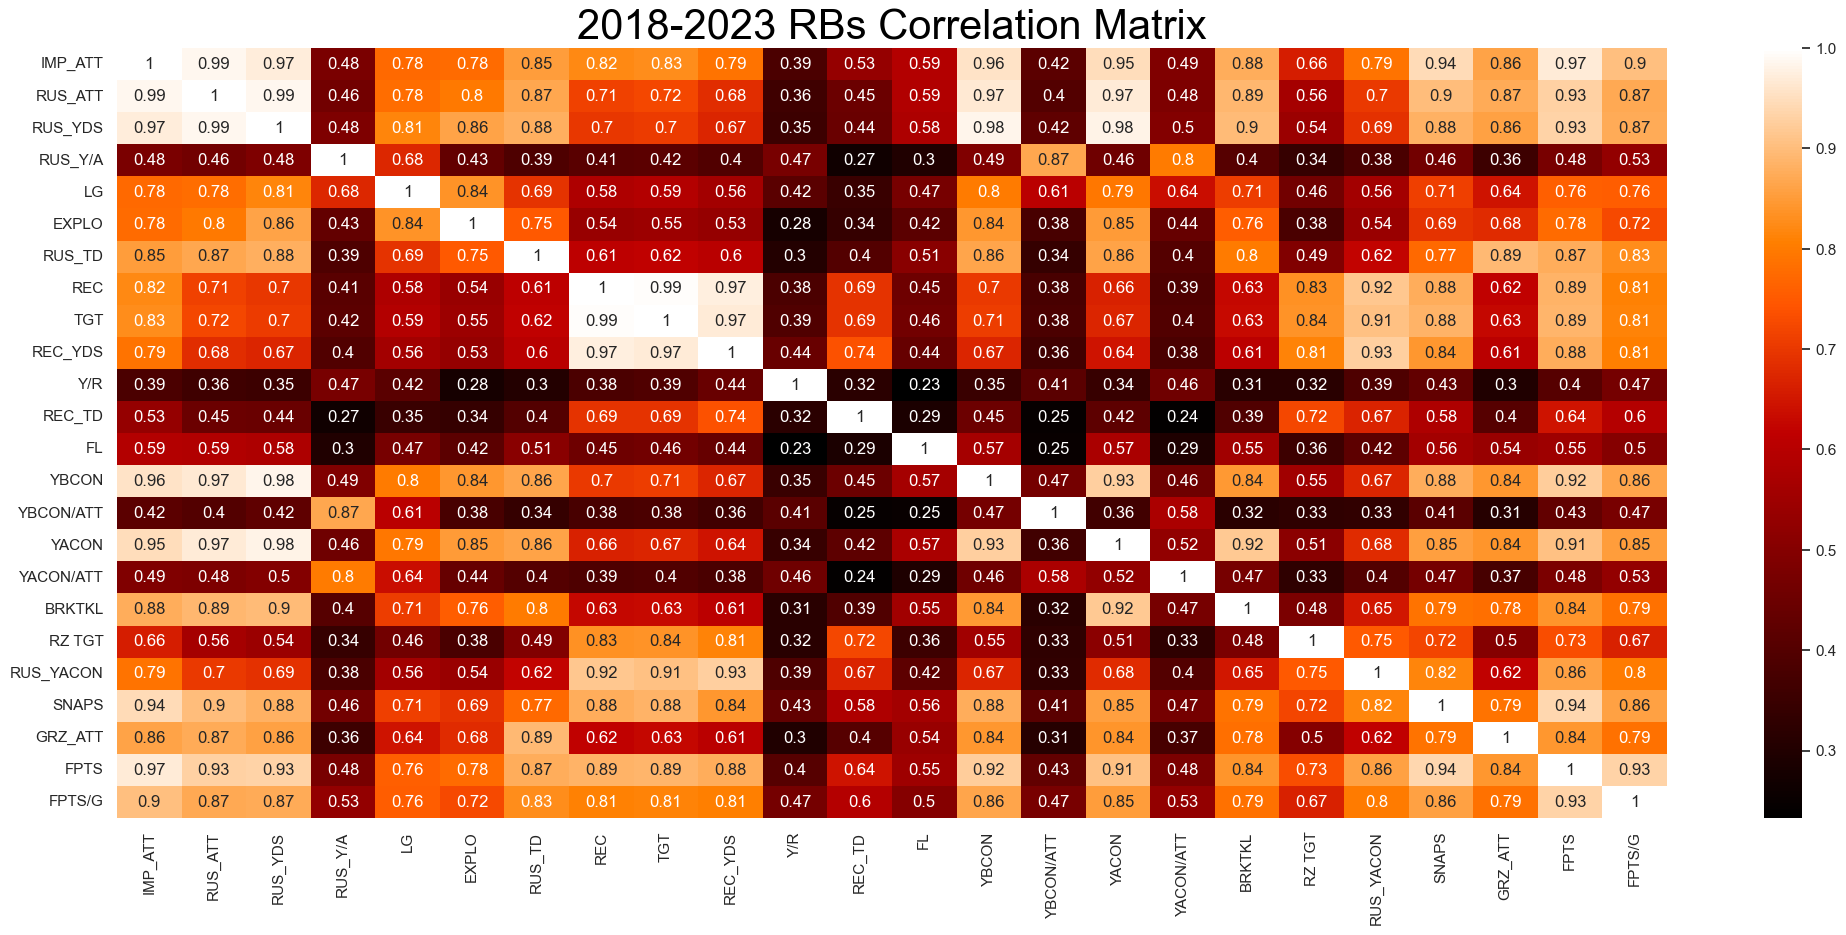

In [26]:
rb_corr = correlation_matrix(rbs_df, 'RB')
rb_corr

## RB Stats Correlations
Running Back Stats with an over 0.75 Correlation Coefficient:
- Implied Attempts - 0.97
- Rush Attempts - 0.93
- Rush Yards - 0.92
- Explosive Plays - 0.78
- Rush Touchdowns - 0.87
- Receptions - 0.889
- Targets - 0.89
- Recieving Yards - 0.88
- Yards Before Catch - 0.92
- Yards After Catch - 0.91
- Broken Tackles - 0.84
- Rush Yards After Contact - 0.86
- Snaps - 0.93
- Green Zone Attempts - 0.83

Stats the Stand Out:
- **Implied Attempts (0.97)**
- **Snaps (0.93)**
- **Broken Tackles (0.84)**
- **Green Zone Attempts (0.83)**
- **Explosive Plays (0.78)**

**IMPLIED ATTEMPTS (0.97)**:
- Implied Attempts = Rushing Attempts + Targets. More touches means more opportunity to score.

**SNAPS (0.93)**:
- How many plays a running back was on the field for. The more often a back is on the field, the more opportunity they will have to score. 

**BROKEN TACKLES (0.84)**:
- How many tackles a running back broke. Gives an indication of how "elusive" or "powerful" a running back is

**GREEN ZONE ATTEMPTS (0.83)**:
- How many plays were between the 5 yard line and opponents endzone. Indicates how often a running back has the opportunity to score a TD

**EXPLOSIVE PLAYS (0.78)**:
- Number of plays that went over 20+ yards. This stats gives an indication of how "explosive" a running back is, or their "big play" making ability

We will look for the RBs who were top 30 in all of these stats

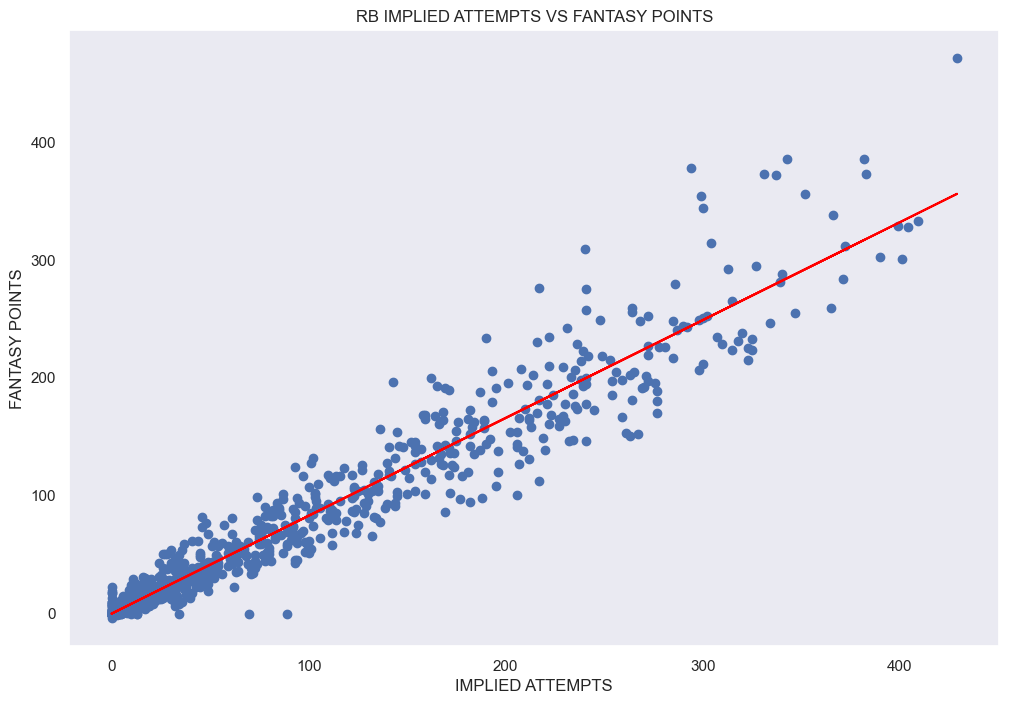

In [27]:
x = rbs_df['IMP_ATT']
y = rbs_df['FPTS']
title = 'RB IMPLIED ATTEMPTS VS FANTASY POINTS'
x_label = 'IMPLIED ATTEMPTS'
y_label = 'FANTASY POINTS'
rb_lin_1 = linear_regression(x,y, title, x_label, y_label)
rb_lin_1

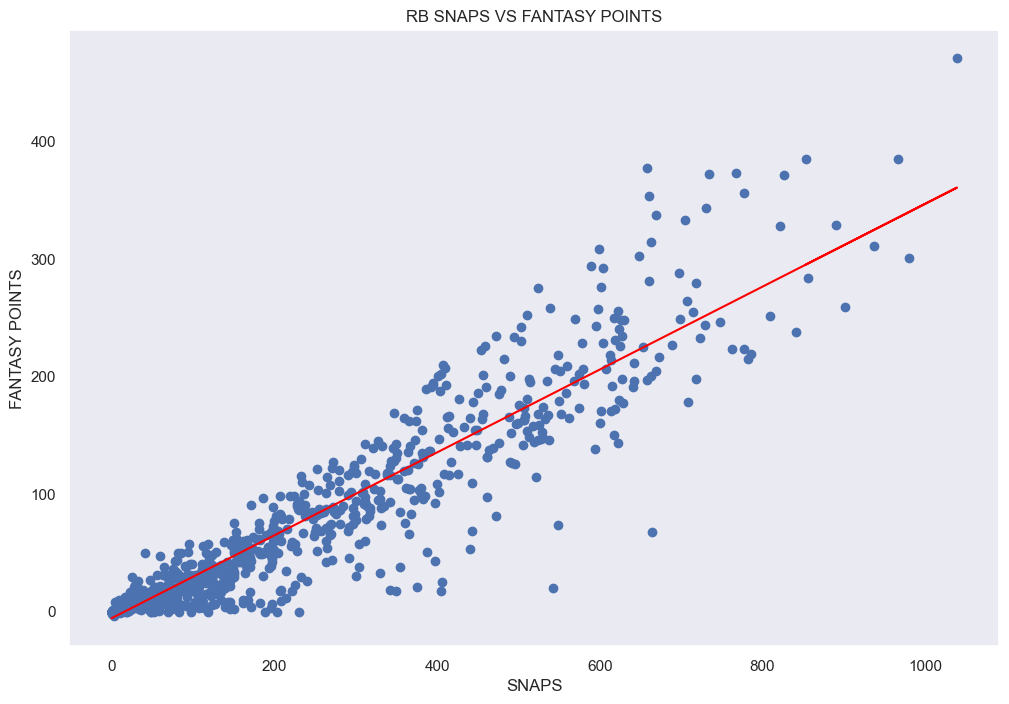

In [28]:
x = rbs_df['SNAPS']
y = rbs_df['FPTS']
title = 'RB SNAPS VS FANTASY POINTS'
x_label = 'SNAPS'
y_label = 'FANTASY POINTS'
rb_lin_2 = linear_regression(x,y, title, x_label, y_label)
rb_lin_2

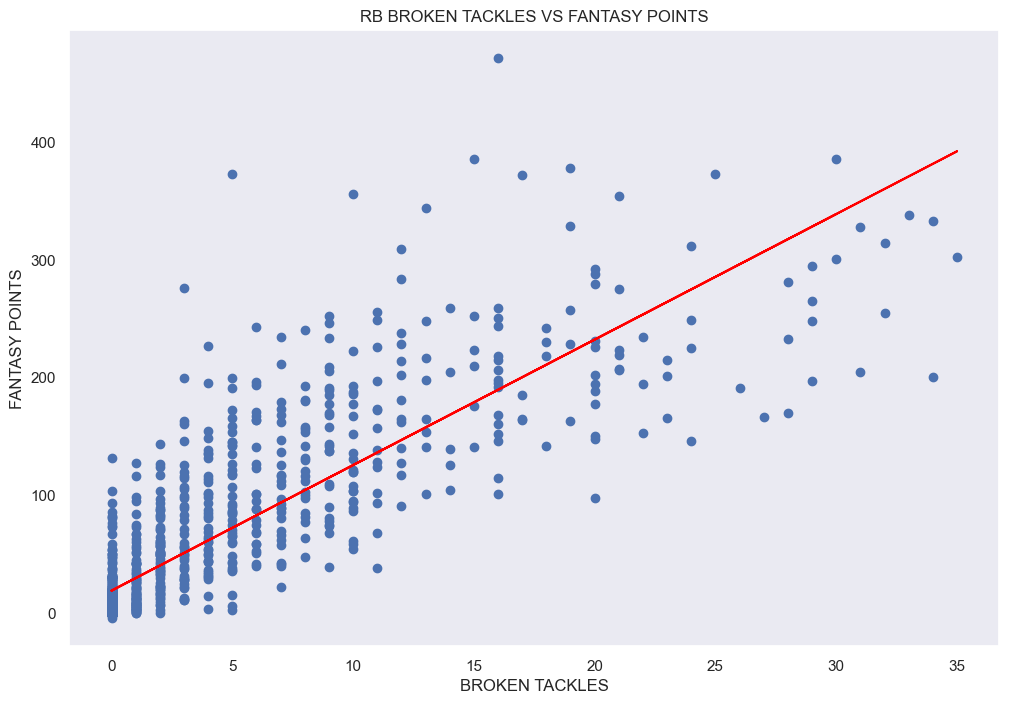

In [29]:
x = rbs_df['BRKTKL']
y = rbs_df['FPTS']
title = 'RB BROKEN TACKLES VS FANTASY POINTS'
x_label = 'BROKEN TACKLES'
y_label = 'FANTASY POINTS'
rb_lin_3 = linear_regression(x,y, title, x_label, y_label)
rb_lin_3

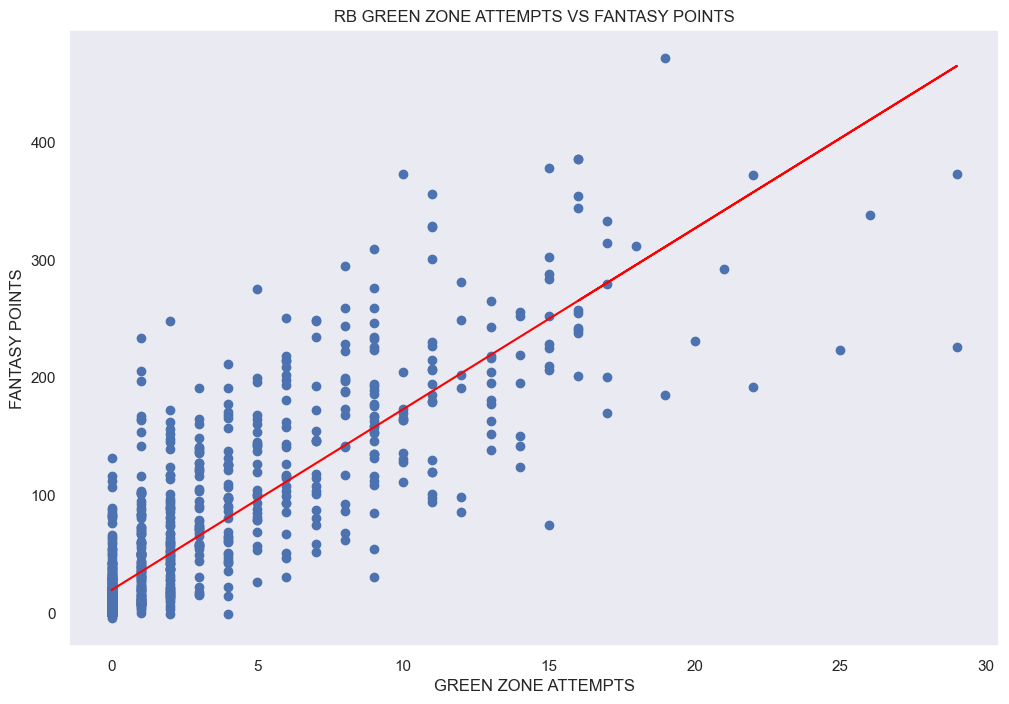

In [30]:
x = rbs_df['GRZ_ATT']
y = rbs_df['FPTS']
title = 'RB GREEN ZONE ATTEMPTS VS FANTASY POINTS'
x_label = 'GREEN ZONE ATTEMPTS'
y_label = 'FANTASY POINTS'
rb_lin_4 = linear_regression(x,y, title, x_label, y_label)
rb_lin_4

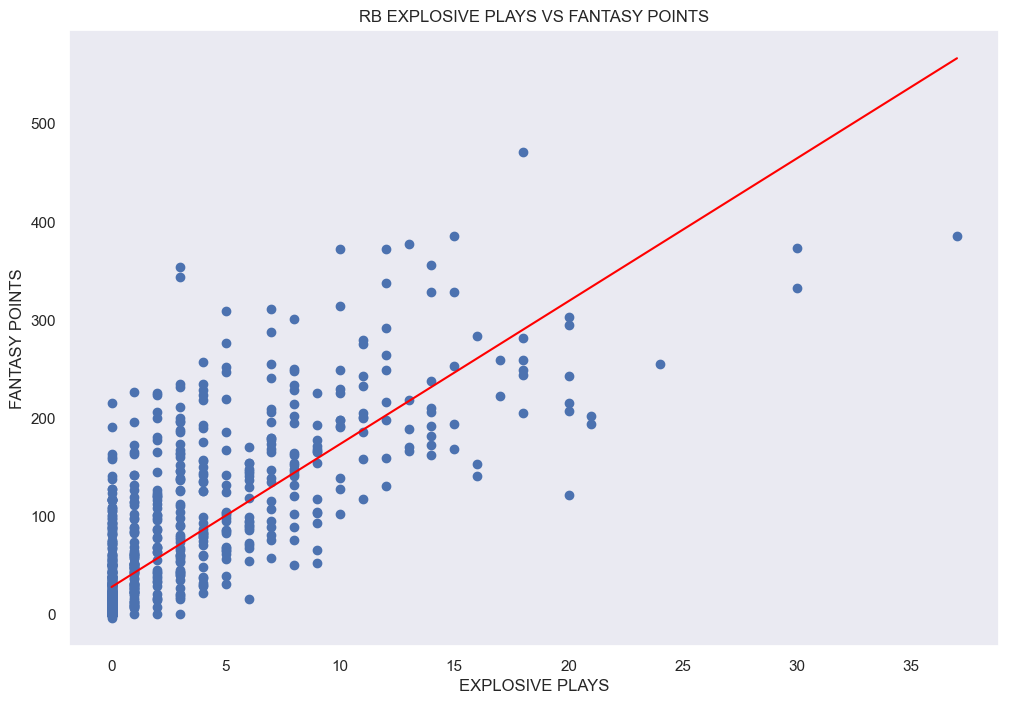

In [31]:
x = rbs_df['EXPLO']
y = rbs_df['FPTS']
title = 'RB EXPLOSIVE PLAYS VS FANTASY POINTS'
x_label = 'EXPLOSIVE PLAYS'
y_label = 'FANTASY POINTS'
rb_lin_5 = linear_regression(x,y, title, x_label, y_label)
rb_lin_5

## Observing the RB Data

In [32]:
#INIT
rb_stats = ['IMP_ATT', 'SNAPS', 'BRKTKL', 'GRZ_ATT', 'EXPLO']
rank = '30'

rb_2018 = comp_all_stats('rb', '2018', rb_stats, rank)
rb_2019 = comp_all_stats('rb', '2019', rb_stats, rank)
rb_2020 = comp_all_stats('rb', '2020', rb_stats, rank)
rb_2021 = comp_all_stats('rb', '2021', rb_stats, rank)

In [33]:
rb_2018

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_IMP_ATT,2019_IMP_ATT,2018_SNAPS,2019_SNAPS,2018_BRKTKL,2019_BRKTKL,2018_GRZ_ATT,2019_GRZ_ATT,2018_EXPLO,2019_EXPLO,CHANGE,IMPROVE
0,Ezekiel Elliott,5.0,3.0,329.1,311.7,399.0,372.0,890.0,937.0,19.0,24.0,11.0,18.0,15.0,7.0,2.0,True
1,Saquon Barkley,1.0,10.0,385.8,244.1,382.0,290.0,853.0,729.0,30.0,16.0,16.0,8.0,37.0,18.0,-9.0,False
2,Christian McCaffrey,2.0,1.0,385.5,471.2,343.0,429.0,966.0,1039.0,15.0,16.0,16.0,19.0,15.0,18.0,1.0,True
3,Todd Gurley II,3.0,14.0,372.1,219.4,337.0,272.0,826.0,786.0,17.0,21.0,22.0,14.0,12.0,5.0,-11.0,False
4,Chris Carson,15.0,12.0,201.4,232.6,271.0,325.0,456.0,723.0,23.0,28.0,16.0,9.0,11.0,11.0,3.0,True
5,Phillip Lindsay,13.0,19.0,222.8,197.7,239.0,272.0,454.0,513.0,10.0,29.0,8.0,8.0,17.0,12.0,-6.0,False


In [34]:
rb_2018.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_IMP_ATT,2019_IMP_ATT,2018_SNAPS,2019_SNAPS,2018_BRKTKL,2019_BRKTKL,2018_GRZ_ATT,2019_GRZ_ATT,2018_EXPLO,2019_EXPLO,CHANGE
count,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,6.500000,9.833333,316.116667,279.45000,328.500000,326.666667,740.833333,787.833333,19.000000,22.333333,14.833333,12.666667,17.833333,11.833333,-3.333333
std,5.991661,6.794606,83.475060,101.53003,62.340196,63.010052,226.357608,183.595661,6.899275,5.680376,4.833908,5.046451,9.641922,5.419102,6.088240
min,1.000000,1.000000,201.400000,197.70000,239.000000,272.000000,454.000000,513.000000,10.000000,16.000000,8.000000,8.000000,11.000000,5.000000,-11.000000
25%,2.250000,4.750000,249.375000,222.70000,287.500000,276.500000,548.500000,724.500000,15.500000,17.250000,12.250000,8.250000,12.750000,8.000000,-8.250000
50%,4.000000,11.000000,350.600000,238.35000,340.000000,307.500000,839.500000,757.500000,18.000000,22.500000,16.000000,11.500000,15.000000,11.500000,-2.500000
75%,11.000000,13.500000,382.150000,294.80000,372.250000,360.250000,880.750000,899.250000,22.000000,27.000000,16.000000,17.000000,16.500000,16.500000,1.750000
max,15.000000,19.000000,385.800000,471.20000,399.000000,429.000000,966.000000,1039.000000,30.000000,29.000000,22.000000,19.000000,37.000000,18.000000,3.000000


In [35]:
rb_2019

,NAME,2019_RANK,2020_RANK,2019_FPTS,2020_FPTS,2019_IMP_ATT,2020_IMP_ATT,2019_SNAPS,2020_SNAPS,2019_BRKTKL,2020_BRKTKL,2019_GRZ_ATT,2020_GRZ_ATT,2019_EXPLO,2020_EXPLO,CHANGE,IMPROVE
0,Ezekiel Elliott,3.0,9.0,311.7,223.7,372.0,315.0,937.0,777.0,24.0,15.0,18.0,25.0,7.0,4.0,-6.0,False
1,Nick Chubb,8.0,11.0,255.2,207.7,347.0,208.0,714.0,410.0,32.0,21.0,16.0,11.0,24.0,20.0,-3.0,False
2,Derrick Henry,5.0,3.0,294.6,333.1,327.0,409.0,589.0,705.0,29.0,34.0,8.0,17.0,20.0,30.0,2.0,True
3,Chris Carson,12.0,19.0,232.6,187.8,325.0,187.0,723.0,404.0,28.0,10.0,9.0,8.0,11.0,3.0,-7.0,False
4,Dalvin Cook,6.0,2.0,292.4,337.8,313.0,366.0,604.0,669.0,20.0,33.0,21.0,26.0,12.0,12.0,4.0,True
5,Aaron Jones,2.0,5.0,314.8,258.9,304.0,264.0,663.0,539.0,32.0,14.0,17.0,9.0,10.0,17.0,-3.0,False
6,Josh Jacobs,21.0,8.0,191.6,231.3,269.0,318.0,460.0,619.0,26.0,20.0,12.0,20.0,14.0,3.0,13.0,True
7,Alvin Kamara,9.0,1.0,248.5,377.8,268.0,294.0,626.0,658.0,29.0,19.0,7.0,15.0,8.0,13.0,8.0,True


In [36]:
rb_2019.describe()

,2019_RANK,2020_RANK,2019_FPTS,2020_FPTS,2019_IMP_ATT,2020_IMP_ATT,2019_SNAPS,2020_SNAPS,2019_BRKTKL,2020_BRKTKL,2019_GRZ_ATT,2020_GRZ_ATT,2019_EXPLO,2020_EXPLO,CHANGE
count,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,8.250000,7.250000,267.675000,269.76250,315.625000,295.125000,664.500000,597.625000,27.500000,20.750000,13.500000,16.375000,13.250000,12.750000,1.000000
std,6.088631,5.922114,43.154564,70.30704,35.784823,74.795793,137.733698,135.768645,4.070802,8.647873,5.209881,6.926914,5.922114,9.528154,7.050836
min,2.000000,1.000000,191.600000,187.80000,268.000000,187.000000,460.000000,404.000000,20.000000,10.000000,7.000000,8.000000,7.000000,3.000000,-7.000000
25%,4.500000,2.750000,244.525000,219.70000,295.250000,250.000000,600.250000,506.750000,25.500000,14.750000,8.750000,10.500000,9.500000,3.750000,-3.750000
50%,7.000000,6.500000,273.800000,245.10000,319.000000,304.500000,644.500000,638.500000,28.500000,19.500000,14.000000,16.000000,11.500000,12.500000,-0.500000
75%,9.750000,9.500000,298.875000,334.27500,332.000000,330.000000,716.250000,678.000000,29.750000,24.000000,17.250000,21.250000,15.500000,17.750000,5.000000
max,21.000000,19.000000,314.800000,377.80000,372.000000,409.000000,937.000000,777.000000,32.000000,34.000000,21.000000,26.000000,24.000000,30.000000,13.000000


In [37]:
rb_2020

,NAME,2020_RANK,2021_RANK,2020_FPTS,2021_FPTS,2020_IMP_ATT,2021_IMP_ATT,2020_SNAPS,2021_SNAPS,2020_BRKTKL,2021_BRKTKL,2020_GRZ_ATT,2021_GRZ_ATT,2020_EXPLO,2021_EXPLO,CHANGE,IMPROVE
0,Derrick Henry,3.0,22.0,333.1,193.3,409.0,239.0,705.0,411.0,34.0,10.0,17.0,9.0,30.0,9.0,-19.0,False
1,Dalvin Cook,2.0,16.0,337.8,206.3,366.0,298.0,669.0,608.0,33.0,16.0,26.0,15.0,12.0,14.0,-14.0,False
2,David Montgomery,4.0,20.0,264.8,196.0,315.0,276.0,707.0,642.0,29.0,16.0,13.0,13.0,12.0,7.0,-16.0,False
3,Alvin Kamara,1.0,8.0,377.8,234.7,294.0,307.0,658.0,627.0,19.0,22.0,15.0,9.0,13.0,4.0,-7.0,False
4,Jonathan Taylor,6.0,1.0,252.8,373.1,272.0,383.0,511.0,767.0,15.0,25.0,15.0,29.0,15.0,30.0,5.0,True
5,Aaron Jones,5.0,11.0,258.9,229.0,264.0,236.0,539.0,578.0,14.0,12.0,9.0,8.0,17.0,8.0,-6.0,False
6,James Conner,27.0,5.0,164.6,257.7,212.0,241.0,562.0,598.0,17.0,19.0,10.0,16.0,8.0,4.0,22.0,True
7,Nick Chubb,11.0,13.0,207.7,215.3,208.0,253.0,410.0,482.0,21.0,23.0,11.0,11.0,20.0,20.0,-2.0,False


In [38]:
rb_2020.describe()

,2020_RANK,2021_RANK,2020_FPTS,2021_FPTS,2020_IMP_ATT,2021_IMP_ATT,2020_SNAPS,2021_SNAPS,2020_BRKTKL,2021_BRKTKL,2020_GRZ_ATT,2021_GRZ_ATT,2020_EXPLO,2021_EXPLO,CHANGE
count,8.00000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,7.37500,12.000000,274.68750,238.175000,292.500000,279.125000,595.125000,589.125000,22.750000,17.87500,14.500000,13.750000,15.875000,12.000000,-4.625000
std,8.50105,7.250616,71.17388,58.571098,70.036725,50.055505,106.633468,106.658919,8.084376,5.33017,5.398412,6.819091,6.749339,9.023778,13.308832
min,1.00000,1.000000,164.60000,193.300000,208.000000,236.000000,410.000000,411.000000,14.000000,10.00000,9.000000,8.000000,8.000000,4.000000,-19.000000
25%,2.75000,7.250000,241.52500,203.725000,251.000000,240.500000,532.000000,554.000000,16.500000,15.00000,10.750000,9.000000,12.000000,6.250000,-14.500000
50%,4.50000,12.000000,261.85000,222.150000,283.000000,264.500000,610.000000,603.000000,20.000000,17.50000,14.000000,12.000000,14.000000,8.500000,-6.500000
75%,7.25000,17.000000,334.27500,240.450000,327.750000,300.250000,678.000000,630.750000,30.000000,22.25000,15.500000,15.250000,17.750000,15.500000,-0.250000
max,27.00000,22.000000,377.80000,373.100000,409.000000,383.000000,707.000000,767.000000,34.000000,25.00000,26.000000,29.000000,30.000000,30.000000,22.000000


In [39]:
rb_2021

,NAME,2021_RANK,2022_RANK,2021_FPTS,2022_FPTS,2021_IMP_ATT,2022_IMP_ATT,2021_SNAPS,2022_SNAPS,2021_BRKTKL,2022_BRKTKL,2021_GRZ_ATT,2022_GRZ_ATT,2021_EXPLO,2022_EXPLO,CHANGE,IMPROVE
0,Najee Harris,3.0,14.0,300.7,223.5,401.0,325.0,980.0,763.0,30.0,21.0,11.0,9.0,8.0,2.0,-11.0,False
1,Joe Mixon,4.0,10.0,287.9,240.7,340.0,287.0,697.0,624.0,20.0,8.0,15.0,16.0,7.0,7.0,-6.0,False
2,Dalvin Cook,16.0,11.0,206.3,237.8,298.0,320.0,608.0,841.0,16.0,12.0,15.0,16.0,14.0,14.0,5.0,True
3,David Montgomery,20.0,24.0,196.0,177.7,276.0,241.0,642.0,629.0,16.0,20.0,13.0,4.0,7.0,2.0,-4.0,False
4,Leonard Fournette,6.0,12.0,255.6,227.1,264.0,272.0,623.0,689.0,11.0,4.0,14.0,11.0,7.0,1.0,-6.0,False
5,Nick Chubb,13.0,6.0,215.3,281.4,253.0,339.0,482.0,660.0,23.0,28.0,11.0,12.0,20.0,18.0,7.0,True
6,Aaron Jones,11.0,9.0,229.0,248.6,236.0,285.0,578.0,630.0,12.0,13.0,8.0,2.0,8.0,10.0,2.0,True


In [40]:
rb_2021.describe()

,2021_RANK,2022_RANK,2021_FPTS,2022_FPTS,2021_IMP_ATT,2022_IMP_ATT,2021_SNAPS,2022_SNAPS,2021_BRKTKL,2022_BRKTKL,2021_GRZ_ATT,2022_GRZ_ATT,2021_EXPLO,2022_EXPLO,CHANGE
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,10.428571,12.285714,241.542857,233.828571,295.428571,295.571429,658.571429,690.857143,18.285714,15.142857,12.428571,10.000000,10.142857,7.714286,-1.857143
std,6.399405,5.736267,40.841925,31.215899,57.497412,34.321311,156.290176,82.363885,6.651172,8.295151,2.572751,5.446712,5.014265,6.600866,6.618876
min,3.000000,6.000000,196.000000,177.700000,236.000000,241.000000,482.000000,624.000000,11.000000,4.000000,8.000000,2.000000,7.000000,1.000000,-11.000000
25%,5.000000,9.500000,210.800000,225.300000,258.500000,278.500000,593.000000,629.500000,14.000000,10.000000,11.000000,6.500000,7.000000,2.000000,-6.000000
50%,11.000000,11.000000,229.000000,237.800000,276.000000,287.000000,623.000000,660.000000,16.000000,13.000000,13.000000,11.000000,8.000000,7.000000,-4.000000
75%,14.500000,13.000000,271.750000,244.650000,319.000000,322.500000,669.500000,726.000000,21.500000,20.500000,14.500000,14.000000,11.000000,12.000000,3.500000
max,20.000000,24.000000,300.700000,281.400000,401.000000,339.000000,980.000000,841.000000,30.000000,28.000000,15.000000,16.000000,20.000000,18.000000,7.000000


## Quick Analysis of Past 5 Years RB Data
We can see that the running back position has more volitility in predicting the future rankings of players, but what we can see is that **every single running back who were top 30 in these Implied Attempts, Snaps, Broken Tackles, Green Zone Attempts, Explosive Plays all ranked within the top 20 the following year** with the exception of Derrick Henry in 2021, and David Montegomery in 2022. While they remained in the top 24, most players fell in their rankings the following year. In last the 5 seasons, 17/29 Running backs fell in their rankings the following year. But what is important to note is the **running backs who were top 30 in all five stats but were ranked outside the top 15 went on to rise into the top 12 the following year**, with the exception of David Montgomery in 2021

- Chris Carson (2018):-----Rank 15 -> Rank 12
- Josh Jacobs (2019): -----> Rank 21 -> Rank 8
- James Connor (2020): -----> Rank 27 -> Rank 5
- Dalvin Cook (2021): ----- Rank 16 -> Rank 11

Let's look at the players who were top 30 in all 5 stats in 2022.

In [41]:
rbs_2023 = get_2023_players('rb', '2022', rb_stats, '30')
rbs_2023

,NAME,2022_RANK,2022_FPTS,2022_IMP_ATT,2022_SNAPS,2022_BRKTKL,2022_GRZ_ATT,2022_EXPLO,AGE,ADP
3,Christian McCaffrey,2.0,356.4,352.0,777.0,10.0,11.0,14.0,27.0,2
2,Saquon Barkley,5.0,284.0,371.0,856.0,12.0,15.0,16.0,26.0,8
4,Nick Chubb,6.0,281.4,339.0,660.0,28.0,12.0,18.0,27.0,14
12,Jonathan Taylor,33.0,146.4,232.0,524.0,24.0,9.0,8.0,24.0,15
1,Derrick Henry,4.0,302.8,390.0,648.0,35.0,15.0,20.0,29.0,17
11,Tony Pollard,8.0,248.8,248.0,569.0,11.0,7.0,18.0,26.0,20
0,Josh Jacobs,3.0,328.3,404.0,821.0,31.0,11.0,14.0,25.0,21
6,Rhamondre Stevenson,7.0,249.1,298.0,699.0,24.0,12.0,12.0,25.0,24
9,Travis Etienne Jr.,17.0,205.1,265.0,669.0,14.0,13.0,18.0,24.0,32
7,Joe Mixon,10.0,240.7,287.0,624.0,8.0,16.0,7.0,27.0,34


## Running Backs for the 2023 Season
From our data, there are 15 RBs who were top 24 in our given stats. Based on our data, we see that Dameon Pierce, Miles Sanders, Dalvin Cook, Devin Singletary, and Jeff Wilson should be good value picks this year based on their ADP, as their Average Draft Position is after 4th. The other 6 RBs, McCaffrey, Barkley, Chubb, Taylor, Henry, Pollard, Jacobs, Stevenson, Etienne, and Mixon are going within the first 4 rounds.

We can see that there are several Runningbacks who are ranked outside the top 15:
- **Johnathan Taylor**
- **Travis Etienne Jr.**
- **Dameon Pierce**
- **Miles Sanders**
- **Devin Singletary**
- **Jeff Wilson Jr.**

Based on our previous data we should expect all of these players to take a jump forward into the top 12 next year. But, as we know there are external factors that we must consider when making a decison to draft a player. For example, Dameon Pierce and Devin Singletary not both play on the same team, so it is unlikely both finish within the top 12 next year. But nonetheless, these are all players you should feel cofortable drafting, depending on their ADP.

Round Tiers based on 10-Man League
1st Round RBs: 
- Christian McCaffery
- Saquon Barkley

2nd Round RBs:
- Nick Chubb
- **Johnathan Taylor**
- Derrick Henry

3rd Round RBs:
- Tony Pollard
- Josh Jacobs
- Rhamondre Stevenson

4th Round RBs:
- **Travis Etienne Jr.**
- Joe Mixon 

Other: 
- 5th Round - **Dameon Pierce**
- 6th Round - **Miles Sanders**
- 7th Round - Dalvin Cook
- 14th Round - **Devin Singletary**
- 15th Round - **Jeff Wilson Jr.**

# Wide Receiver Analysis

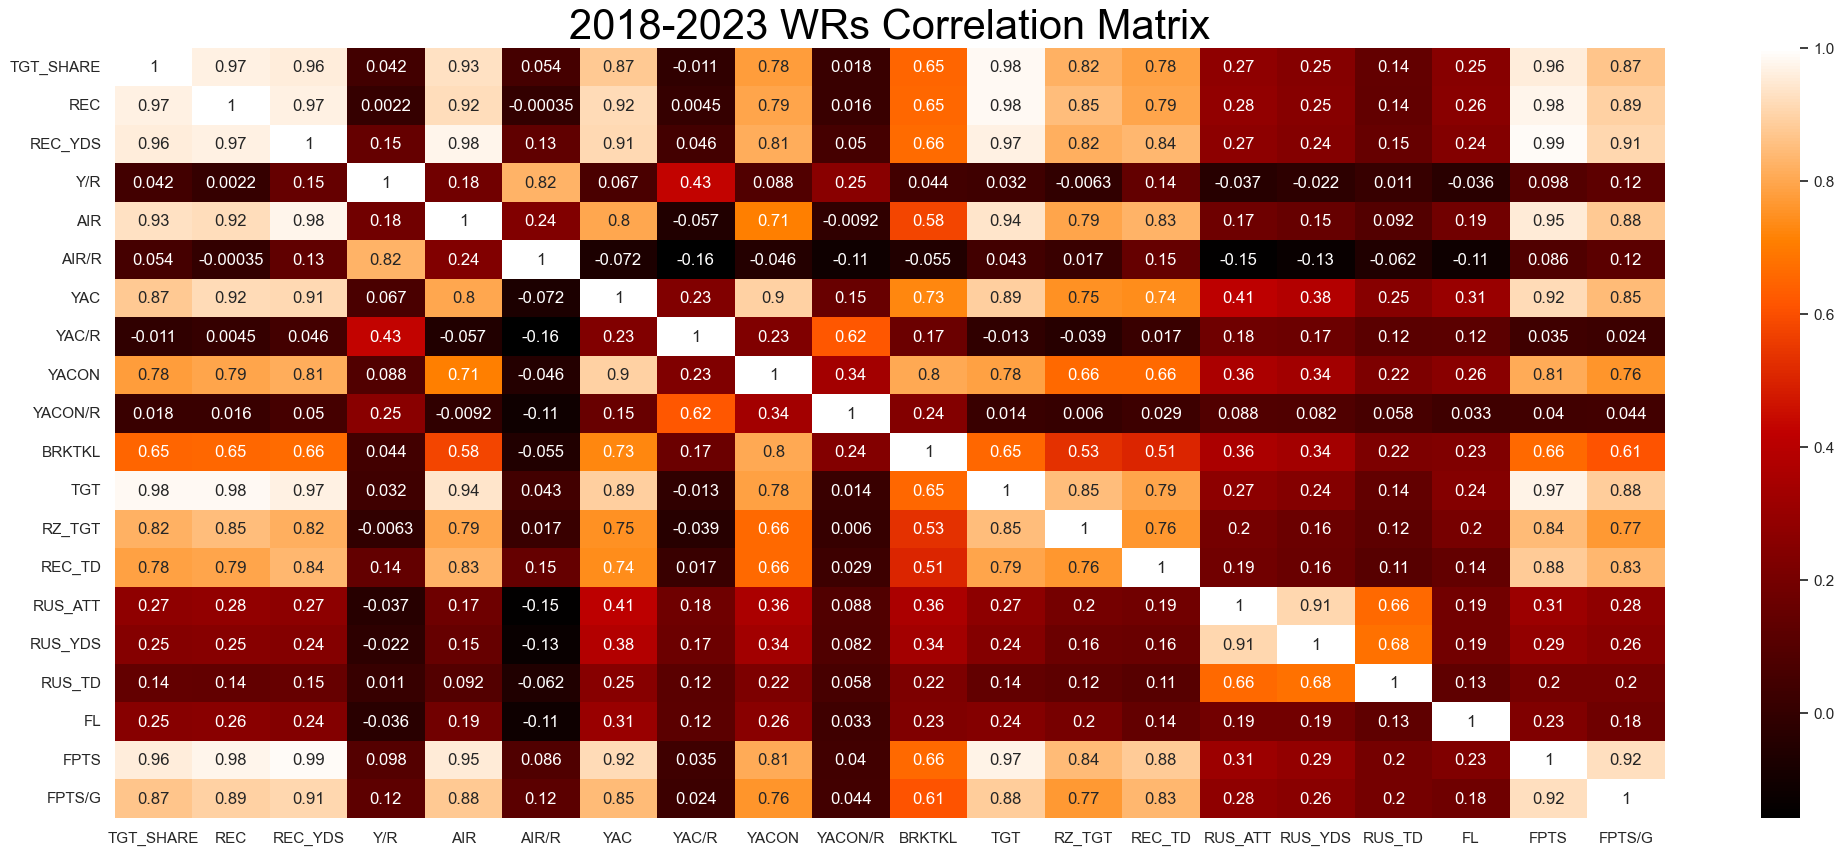

In [42]:
wr_corr = correlation_matrix(wrs_df, 'WR')
wr_corr

## WR Stat Correlations
Wide Receiver Stats with an over 0.75 Correlation Coefficient:

- Target Share (0.96)
- Receptions (0.98)
- Receiving Yards (0.99)
- Air Yards (0.95)
- Yards After Catch (0.92)
- Yards After Contact (0.82)
- Targets (0.97)
- Redzone Targets(0.84)
- Receiving Touchdowns (0.88)

Stats that stand out: 
- **Target Share**
- **Targets**
- **Redzone Targets**

Receptions, Receiving Yards, and Touchdowns are built into PPR Scoring
Air Yards, Yards After Catch, and Yards After Contact are subsets of Receiving Yards, so they will not be considered

**Target Share (0.96)**
- Percentage of Teams Total Targets

**Targets (0.97)**
- Total Number of Targets

**Redzone Targets (0.84)**
- Total Number of Targets when in the Red Zone (Between 20 yard and Opponents Endzone)

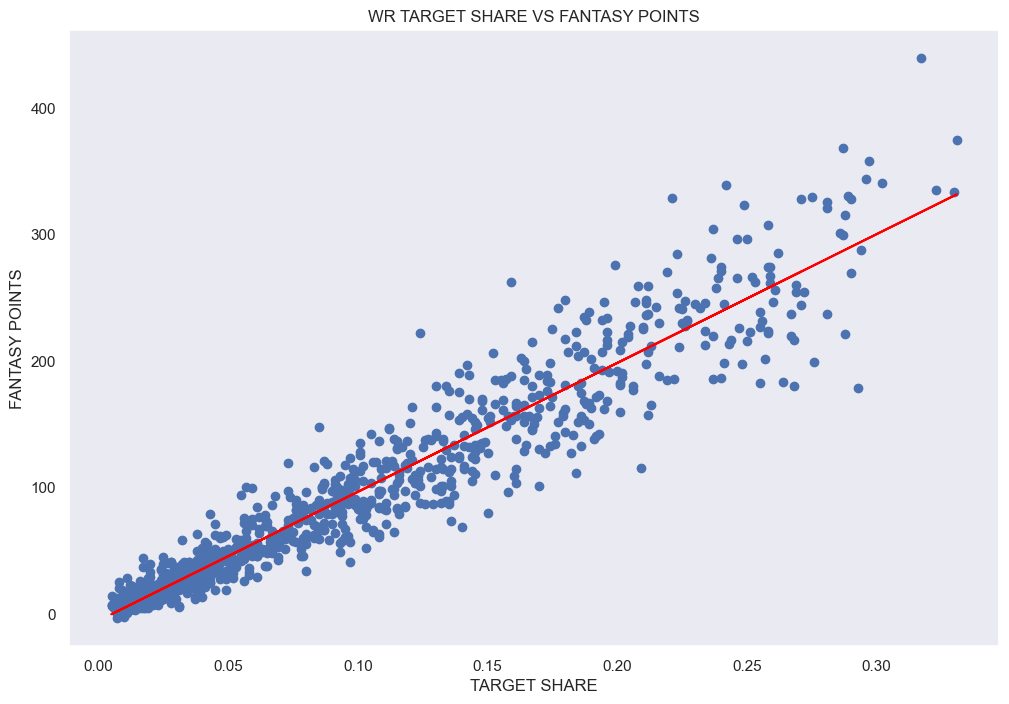

In [43]:
x = wrs_df['TGT_SHARE']
y = wrs_df['FPTS']
title = 'WR TARGET SHARE VS FANTASY POINTS'
x_label = 'TARGET SHARE'
y_label = 'FANTASY POINTS'
wr_lin_1 = linear_regression(x,y, title, x_label, y_label)
wr_lin_1

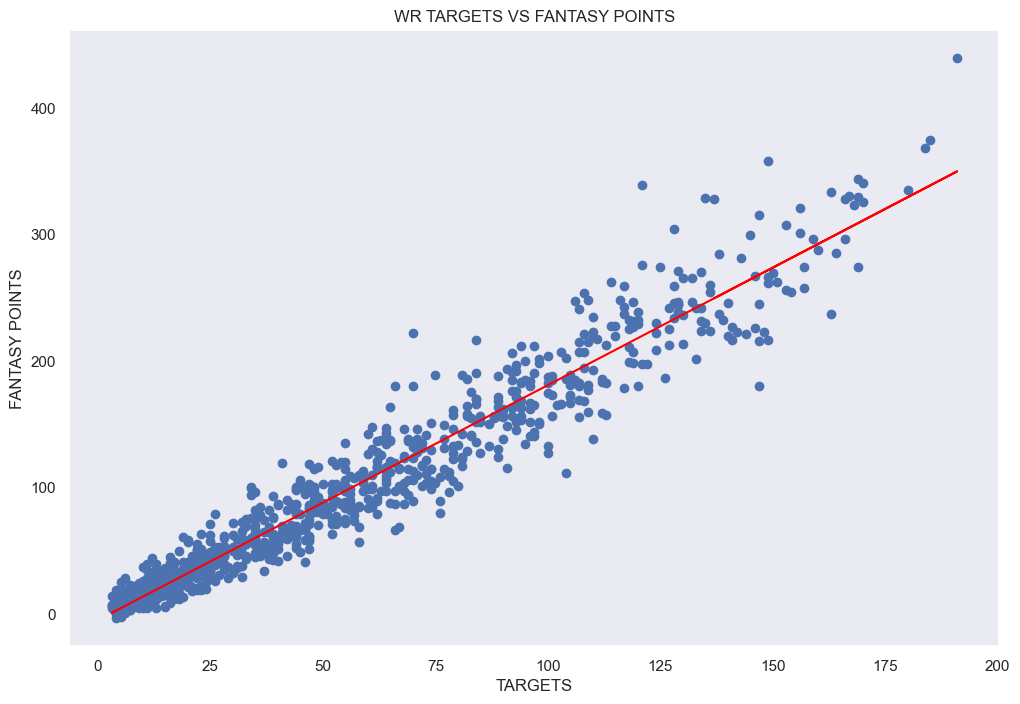

In [44]:
x = wrs_df['TGT']
y = wrs_df['FPTS']
title = 'WR TARGETS VS FANTASY POINTS'
x_label = 'TARGETS'
y_label = 'FANTASY POINTS'
wr_lin_2 = linear_regression(x,y, title, x_label, y_label)
wr_lin_2

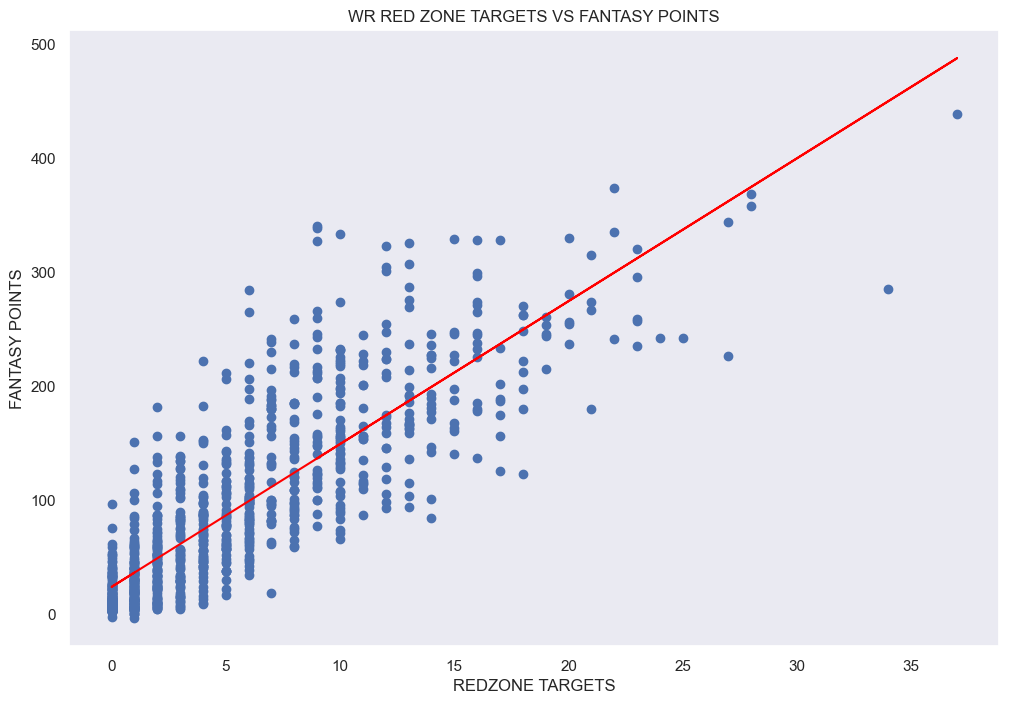

In [45]:
x = wrs_df['RZ_TGT']
y = wrs_df['FPTS']
title = 'WR RED ZONE TARGETS VS FANTASY POINTS'
x_label = 'REDZONE TARGETS'
y_label = 'FANTASY POINTS'
wr_lin_3 = linear_regression(x,y, title, x_label, y_label)
wr_lin_3


## Observing the WR Data

In [46]:
wr_stats=['TGT_SHARE', 'TGT', 'RZ_TGT']
rank = '30'
wr_2018 = comp_all_stats('wr','2018', wr_stats, rank)
wr_2019 = comp_all_stats('wr','2019', wr_stats, rank)
wr_2020 = comp_all_stats('wr','2020', wr_stats, rank)
wr_2021 = comp_all_stats('wr','2021', wr_stats, rank)


In [47]:
wr_2018

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE,IMPROVE
0,DeAndre Hopkins,4.0,9.0,333.5,269.5,0.330,0.290,163.0,150.0,10.0,13.0,-5.0,False
1,Michael Thomas,8.0,1.0,315.5,374.6,0.288,0.331,147.0,185.0,21.0,22.0,7.0,True
2,Julio Jones,5.0,5.0,325.9,274.1,0.281,0.240,170.0,157.0,13.0,16.0,0.0,True
3,Davante Adams,3.0,29.0,329.6,212.7,0.275,0.234,169.0,127.0,15.0,18.0,-26.0,False
4,Tyreek Hill,1.0,28.0,328.0,188.3,0.271,0.159,137.0,89.0,9.0,7.0,-27.0,False
5,Keenan Allen,14.0,11.0,260.1,261.5,0.269,0.259,136.0,149.0,9.0,19.0,3.0,True
6,Jarvis Landry,22.0,14.0,217.1,237.4,0.268,0.267,149.0,138.0,9.0,20.0,8.0,True
7,Stefon Diggs,12.0,18.0,266.3,212.1,0.252,0.213,149.0,94.0,9.0,5.0,-6.0,False
8,Amari Cooper,19.0,7.0,215.5,246.5,0.202,0.207,107.0,119.0,7.0,9.0,12.0,True
9,Julian Edelman,23.0,13.0,207.4,256.3,0.194,0.261,108.0,153.0,9.0,20.0,10.0,True


In [48]:
wr_2018.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000,10.000000,10.0000,10.000000
mean,11.100000,13.500000,279.890000,253.30000,0.263000,0.246100,143.500000,136.10000,11.100000,14.9000,-2.400000
std,8.143846,9.240611,52.667161,50.94099,0.039875,0.047557,22.351982,29.52005,4.175324,6.0452,14.041209
min,1.000000,1.000000,207.400000,188.30000,0.194000,0.159000,107.000000,89.00000,7.000000,5.0000,-27.000000
25%,4.250000,7.500000,227.850000,218.87500,0.256000,0.218250,136.250000,121.00000,9.000000,10.0000,-5.750000
50%,10.000000,12.000000,290.900000,251.40000,0.270000,0.249500,148.000000,143.50000,9.000000,17.0000,1.500000
75%,17.750000,17.000000,327.475000,267.50000,0.279500,0.265500,159.500000,152.25000,12.250000,19.7500,7.750000
max,23.000000,29.000000,333.500000,374.60000,0.330000,0.331000,170.000000,185.00000,21.000000,22.0000,12.000000


In [49]:
wr_2019

,NAME,2019_RANK,2020_RANK,2019_FPTS,2020_FPTS,2019_TGT_SHARE,2020_TGT_SHARE,2019_TGT,2020_TGT,2019_RZ_TGT,2020_RZ_TGT,CHANGE,IMPROVE
0,DeAndre Hopkins,9.0,10.0,269.5,287.8,0.290,0.294,150.0,160.0,13.0,13.0,-1.0,False
1,Allen Robinson II,12.0,12.0,254.9,262.9,0.272,0.253,154.0,151.0,20.0,18.0,0.0,True
2,Keenan Allen,11.0,18.0,261.5,245.1,0.259,0.241,149.0,147.0,19.0,16.0,-7.0,False
3,Davante Adams,29.0,1.0,212.7,358.4,0.234,0.297,127.0,149.0,18.0,28.0,28.0,True
4,DJ Moore,21.0,17.0,230.5,211.5,0.225,0.224,135.0,118.0,12.0,9.0,4.0,True
5,DK Metcalf,30.0,5.0,187.1,271.3,0.202,0.240,100.0,129.0,17.0,16.0,25.0,True
6,Chris Godwin,2.0,30.0,276.1,191.0,0.199,0.139,121.0,84.0,13.0,9.0,-28.0,False


In [50]:
wr_2019.describe()

,2019_RANK,2020_RANK,2019_FPTS,2020_FPTS,2019_TGT_SHARE,2020_TGT_SHARE,2019_TGT,2020_TGT,2019_RZ_TGT,2020_RZ_TGT,CHANGE
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,16.285714,13.285714,241.757143,261.142857,0.240143,0.241143,133.714286,134.000000,16.000000,15.571429,3.000000
std,10.609968,9.551863,32.838131,54.646770,0.034811,0.052888,19.388264,26.267851,3.265986,6.502747,19.131126
min,2.000000,1.000000,187.100000,191.000000,0.199000,0.139000,100.000000,84.000000,12.000000,9.000000,-28.000000
25%,10.000000,7.500000,221.600000,228.300000,0.213500,0.232000,124.000000,123.500000,13.000000,11.000000,-4.000000
50%,12.000000,12.000000,254.900000,262.900000,0.234000,0.241000,135.000000,147.000000,17.000000,16.000000,0.000000
75%,25.000000,17.500000,265.500000,279.550000,0.265500,0.273500,149.500000,150.000000,18.500000,17.000000,14.500000
max,30.000000,30.000000,276.100000,358.400000,0.290000,0.297000,154.000000,160.000000,20.000000,28.000000,28.000000


In [51]:
wr_2020

,NAME,2020_RANK,2021_RANK,2020_FPTS,2021_FPTS,2020_TGT_SHARE,2021_TGT_SHARE,2020_TGT,2021_TGT,2020_RZ_TGT,2021_RZ_TGT,CHANGE,IMPROVE
0,Davante Adams,1.0,5.0,358.4,344.3,0.297,0.296,149.0,169.0,28.0,27.0,-4.0,False
1,Stefon Diggs,3.0,8.0,328.6,285.5,0.290,0.262,166.0,164.0,16.0,34.0,-5.0,False
2,Tyler Lockett,11.0,11.0,265.4,241.4,0.246,0.225,132.0,107.0,16.0,7.0,0.0,True
3,Keenan Allen,18.0,15.0,245.1,257.8,0.241,0.238,147.0,157.0,16.0,23.0,3.0,True
4,DK Metcalf,5.0,10.0,271.3,244.3,0.240,0.271,129.0,129.0,16.0,19.0,-5.0,False
5,Terry McLaurin,23.0,24.0,223.8,213.5,0.234,0.243,134.0,130.0,12.0,9.0,-1.0,False
6,Adam Thielen,7.0,27.0,254.0,199.8,0.223,0.164,108.0,95.0,19.0,13.0,-20.0,False
7,Tyreek Hill,2.0,7.0,328.9,296.5,0.221,0.250,135.0,159.0,17.0,23.0,-5.0,False
8,Amari Cooper,19.0,26.0,236.8,202.5,0.211,0.163,130.0,104.0,14.0,17.0,-7.0,False
9,Cooper Kupp,34.0,1.0,208.7,439.5,0.201,0.317,124.0,191.0,12.0,37.0,33.0,True


In [52]:
wr_2020.describe()

,2020_RANK,2021_RANK,2020_FPTS,2021_FPTS,2020_TGT_SHARE,2021_TGT_SHARE,2020_TGT,2021_TGT,2020_RZ_TGT,2021_RZ_TGT,CHANGE
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,12.300000,13.400000,272.100000,272.510000,0.240400,0.242900,135.40000,140.500000,16.600000,20.900000,-1.100000
std,10.883729,9.252027,50.074234,74.112579,0.031327,0.049965,15.70704,32.139453,4.550946,9.960477,13.444949
min,1.000000,1.000000,208.700000,199.800000,0.201000,0.163000,108.00000,95.000000,12.000000,7.000000,-20.000000
25%,3.500000,7.250000,238.875000,220.475000,0.221500,0.228250,129.25000,112.500000,14.500000,14.000000,-5.000000
50%,9.000000,10.500000,259.700000,251.050000,0.237000,0.246500,133.00000,143.500000,16.000000,21.000000,-4.500000
75%,18.750000,21.750000,314.275000,293.750000,0.244750,0.268750,144.00000,162.750000,16.750000,26.000000,-0.250000
max,34.000000,27.000000,358.400000,439.500000,0.297000,0.317000,166.00000,191.000000,28.000000,37.000000,33.000000


In [53]:
wr_2021

,NAME,2021_RANK,2022_RANK,2021_FPTS,2022_FPTS,2021_TGT_SHARE,2022_TGT_SHARE,2021_TGT,2022_TGT,2021_RZ_TGT,2022_RZ_TGT,CHANGE,IMPROVE
0,Cooper Kupp,1.0,22.0,439.5,201.4,0.317,0.190,191.0,98.0,37.0,11.0,-21.0,False
1,Davante Adams,5.0,2.0,344.3,335.5,0.296,0.323,169.0,180.0,27.0,22.0,3.0,True
2,Justin Jefferson,4.0,1.0,330.4,368.6,0.289,0.287,167.0,184.0,20.0,28.0,3.0,True
3,DK Metcalf,10.0,19.0,244.3,226.8,0.271,0.255,129.0,141.0,19.0,27.0,-9.0,False
4,Stefon Diggs,8.0,5.0,285.5,321.2,0.262,0.281,164.0,156.0,34.0,23.0,3.0,True
5,Michael Pittman Jr.,16.0,27.0,238.6,216.5,0.255,0.244,129.0,141.0,16.0,14.0,-11.0,False
6,Tyreek Hill,7.0,3.0,296.5,341.2,0.250,0.302,159.0,170.0,23.0,9.0,4.0,True
7,Jaylen Waddle,21.0,7.0,245.8,259.2,0.234,0.208,140.0,117.0,15.0,8.0,14.0,True
8,Amon-Ra St. Brown,23.0,9.0,227.3,267.6,0.210,0.259,119.0,146.0,14.0,21.0,14.0,True


In [54]:
wr_2021.describe()

,2021_RANK,2022_RANK,2021_FPTS,2022_FPTS,2021_TGT_SHARE,2022_TGT_SHARE,2021_TGT,2022_TGT,2021_RZ_TGT,2022_RZ_TGT,CHANGE
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,10.555556,10.555556,294.688889,282.000000,0.264889,0.261000,151.888889,148.111111,22.777778,18.111111,0.000000
std,7.731609,9.619136,68.383943,61.200429,0.032781,0.042983,23.766807,28.352445,8.303279,7.720823,11.608187
min,1.000000,1.000000,227.300000,201.400000,0.210000,0.190000,119.000000,98.000000,14.000000,8.000000,-21.000000
25%,5.000000,3.000000,244.300000,226.800000,0.250000,0.244000,129.000000,141.000000,16.000000,11.000000,-9.000000
50%,8.000000,7.000000,285.500000,267.600000,0.262000,0.259000,159.000000,146.000000,20.000000,21.000000,3.000000
75%,16.000000,19.000000,330.400000,335.500000,0.289000,0.287000,167.000000,170.000000,27.000000,23.000000,4.000000
max,23.000000,27.000000,439.500000,368.600000,0.317000,0.323000,191.000000,184.000000,37.000000,28.000000,14.000000


## Quick Analysis of Past 5 Years WR Data
In most years, we can see that **being top 30 in Target Share, Targets, and Red Zone Targets indicated that a player would be a top 24 overall receiver the following year, in many cases top 12**. One trend that appears is that is **a player that was top 30 in all three stats but ranked outside the top 20 overall, they had a large leap in the rankings, often within the top 10 overall the following year**. The only exception was Terry McLaurin in 2020. Some receivers did fall out of the top 24 the following year, but this was often due to injury (Michael Pittman 2021 for example)

NOTE: The year indicates when they were top 3 in Target Share, Targets, and Red Zone Targets. Read as "Year Rank -> Next Year Rank"
- Jarvis Landry (2018):-----Rank 22 -> Rank 14
- Julian Edelman (2018):-----Rank 23 -> Rank 13
- Davante Adams (2019):-----Rank 29 -> Rank 1
- DJ Moore (2019):-----Rank 21 -> Rank 17
- DK Metcalf (2019):-----Rank 30 -> Rank 5
- Terry McLaurin (2020):-----Rank 24 -> Rank 23
- Cooper Kupp (2020):-----Rank 34 -> Rank 1
- Jaylen Waddle (2021):-----Rank 21 -> Rank 7
- Amon-Ra St. Brown (2021):-----Rank 23 -> Rank9

Let's look at the top 30 in Target Share, Targets, and Red Zone Attempts in 2022

In [55]:
wrs_2023 = get_2023_players('wr', '2022', wr_stats, '30')
wrs_2023

,NAME,2022_RANK,2022_FPTS,2022_TGT_SHARE,2022_TGT,2022_RZ_TGT,AGE,ADP
3,Justin Jefferson,1.0,368.6,0.287,184.0,28.0,24.0,1
13,Ja'Marr Chase,12.0,242.4,0.224,134.0,24.0,23.0,3
4,Stefon Diggs,5.0,321.2,0.281,156.0,23.0,29.0,10
2,A.J. Brown,4.0,299.6,0.287,145.0,16.0,26.0,12
0,Davante Adams,2.0,335.5,0.323,180.0,22.0,30.0,13
7,Amon-Ra St. Brown,9.0,267.6,0.259,146.0,21.0,23.0,16
9,Garrett Wilson,21.0,215.7,0.250,147.0,19.0,23.0,18
8,DK Metcalf,19.0,226.8,0.255,141.0,27.0,25.0,33
6,Amari Cooper,8.0,247.0,0.260,132.0,16.0,29.0,38
15,Chris Godwin,26.0,222.8,0.196,142.0,15.0,27.0,57


## Wide Receivers for the 2023 Season
In 2022, there were 14 Wide Receivers who were top 24 in Target Share, Targets, and Redzone Targets. Surprisingly, 5 of these receivers were outside the top 20:
- **Garrett Wilson (21)**
- **Chris Godwin (26)**
- **Michael Pittman Jr. (27)**
- **Zay Jones (29)**
- **Drake London (38)**
- **Diontae Johnson (46)**
Based on the data, we can make a prediction that most of these players will take a leap in the rankings and perform within the top 24 next year, thus making them great value picks depending on their ADP. The other receivers should be very safe picks to finish top 24 in 2024.

Round Tiers based on 10-Man League:
1st Round WRs:
- Justin Jefferson
- Ja'Marr Chase
- Stefon Diggs

2nd Round Wrs:
- A.J. Brown
- Davante Adams
- Amon Ra St. Brown
- **Garrett Wilson**

4th Round WRs:
- DK Metcalf
- Amari Cooper

Other:
- 6th Round - **Drake London**
- 6th Round - **Chris Godwin**
- 7th Round - Brandon Aiyuk
- 7th Round - **Christian Kirk**
- 8th Round - **Michael Pittman Jr.**
- 8th Round - **Diontae Johnson**
- 16th Round - **Zay Jones**


# TE Analysis

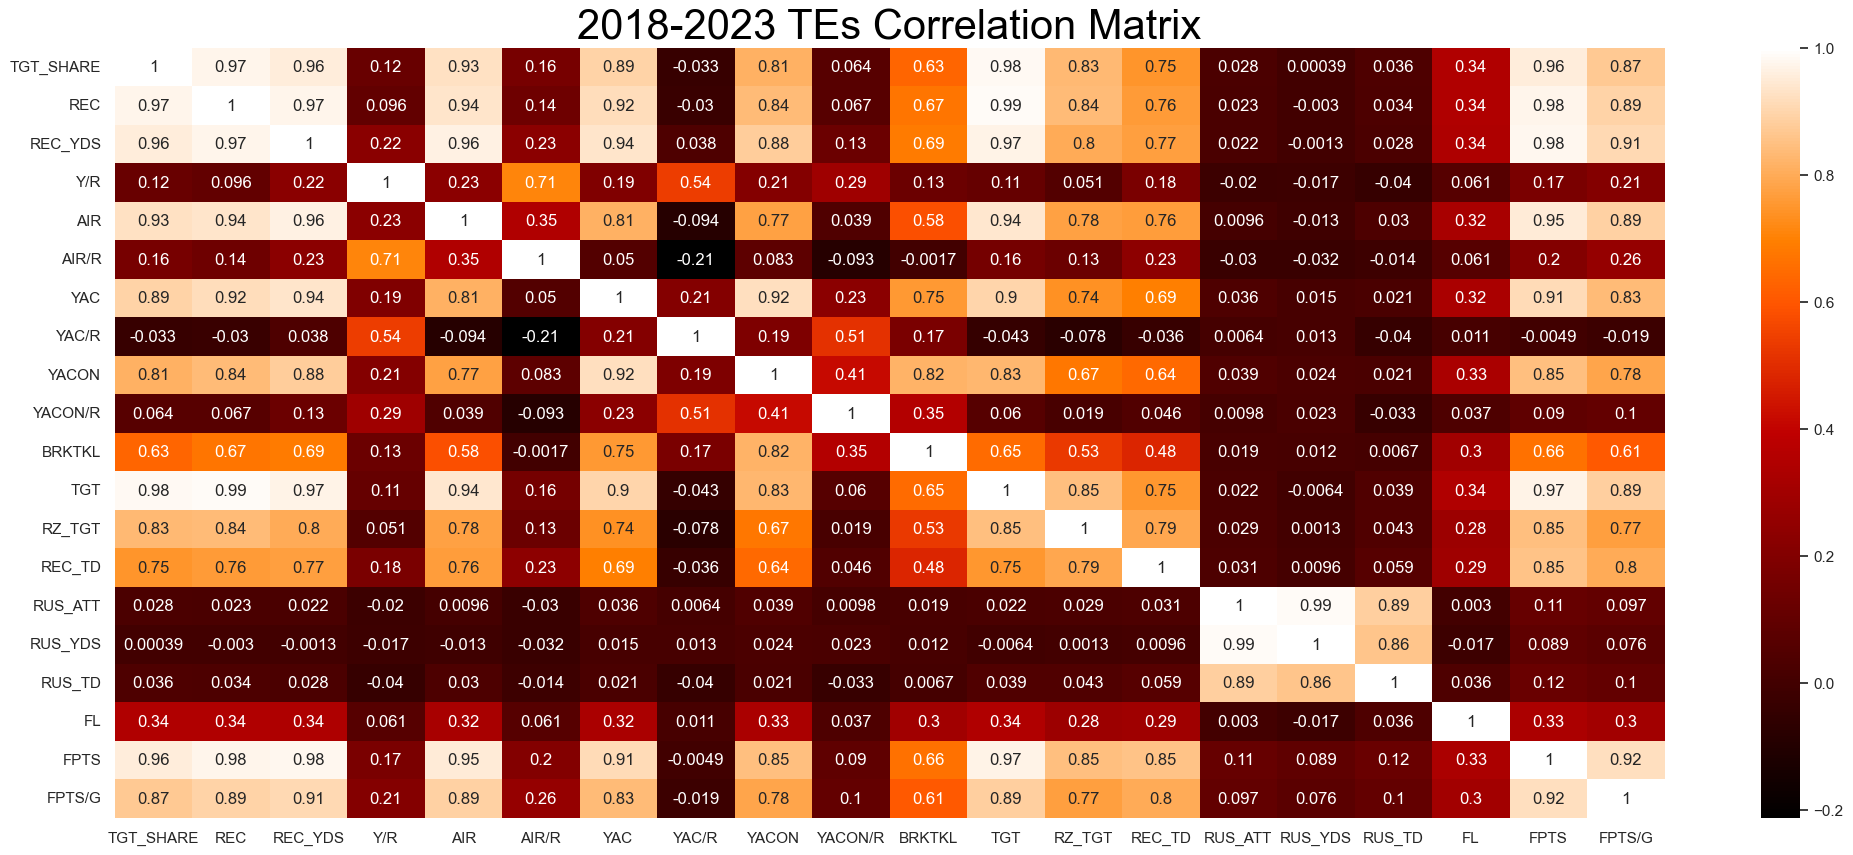

In [56]:
te_corr = correlation_matrix(tes_df, 'TE')
te_corr


## TE Stat Correlations
Tight End Stats with an over 0.75 Correlation Coefficient:

- Target Share (0.96)
- Receptions (0.98)
- Receiving Yards (0.98)
- Air Yards (0.95)
- Yards After Catch (0.91)
- Yards After Contact (0.85)
- Targets (0.97)
- Redzone Targets (0.85)
- Receiving Touchdowns (0.85)

Stats that stand out: 
- **Target Share**
- **Targets**
- **Redzone Targets**

This is very similar to the list of attributes we had with the wide receivers, which makes sense as tight ends only score point when being used as pass catchers. 

Receptions, Receiving Yards, and Touchdowns are built into PPR Scoring
Air Yards, Yards After Catch, and Yards After Contact are subsets of Receiving Yards, so they will not be considered

**Target Share (0.96)**
- Percentage of Teams Total Targets

**Targets (0.97)**
- Total Number of Targets

**Redzone Targets (0.85)**
- Total Number of Targets when in the Red Zone (Between 20 yard and Opponents Endzone)

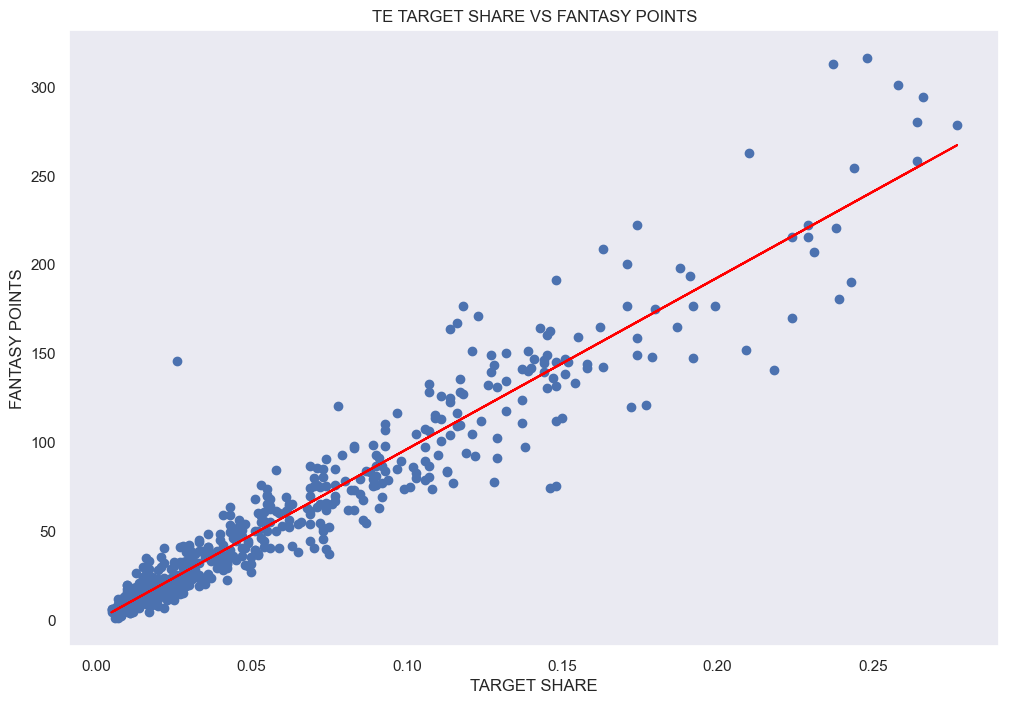

In [57]:
x = tes_df['TGT_SHARE']
y = tes_df['FPTS']
title = 'TE TARGET SHARE VS FANTASY POINTS'
x_label = 'TARGET SHARE'
y_label = 'FANTASY POINTS'
te_lin_1 = linear_regression(x,y, title, x_label, y_label)
te_lin_1 

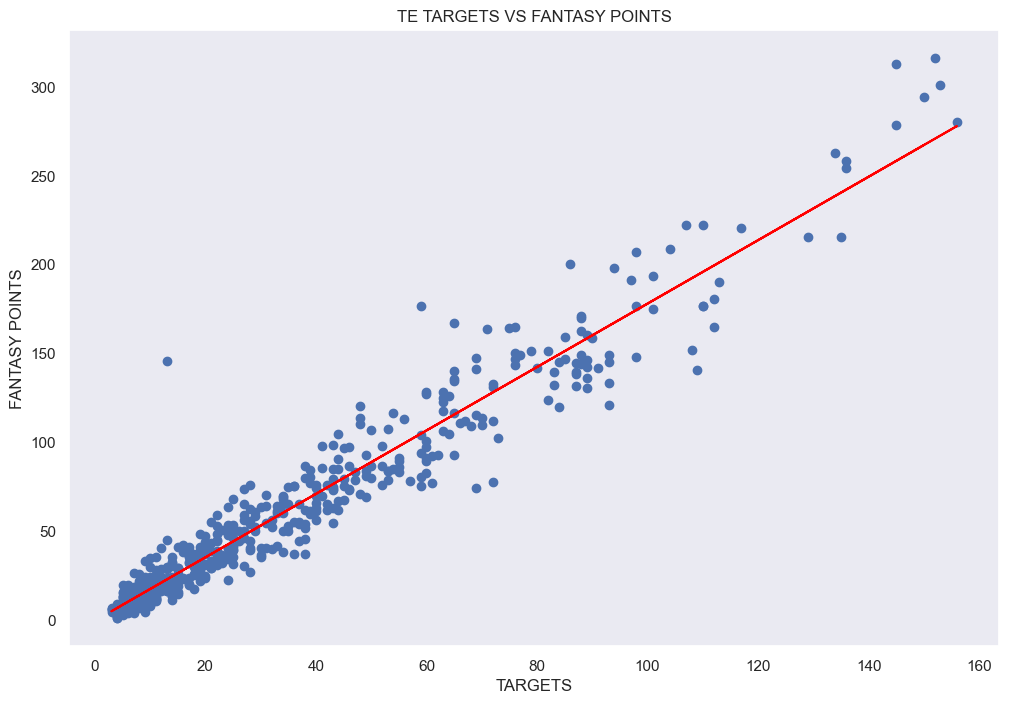

In [58]:
x = tes_df['TGT']
y = tes_df['FPTS']
title = 'TE TARGETS VS FANTASY POINTS'
x_label = 'TARGETS'
y_label = 'FANTASY POINTS'
te_lin_2 = linear_regression(x,y, title, x_label, y_label)
te_lin_2

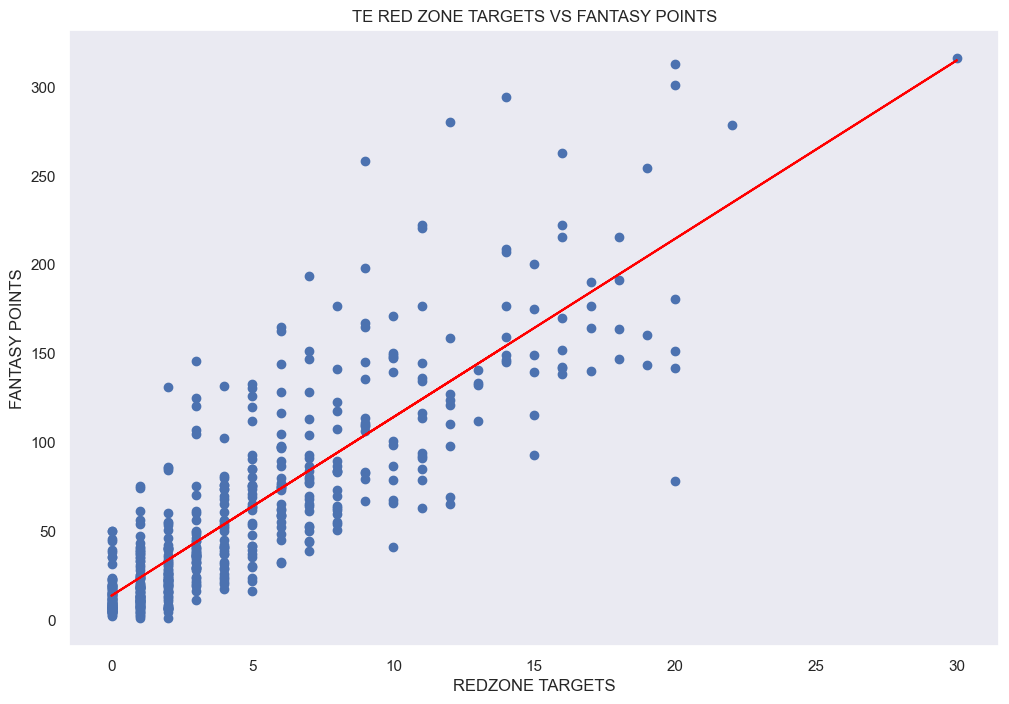

In [59]:
x = tes_df['RZ_TGT']
y = tes_df['FPTS']
title = 'TE RED ZONE TARGETS VS FANTASY POINTS'
x_label = 'REDZONE TARGETS'
y_label = 'FANTASY POINTS'
te_lin_3 = linear_regression(x,y, title, x_label, y_label)
te_lin_3

## Observing the TE Data

In [60]:
te_stats=['TGT_SHARE', 'TGT', 'RZ_TGT']
rank = '15'
te_2018 = comp_all_stats('te', '2018', te_stats, rank)
te_2019 = comp_all_stats('te', '2018', te_stats, rank)
te_2020 = comp_all_stats('te', '2018', te_stats, rank)
te_2021 = comp_all_stats('te', '2018', te_stats, rank)


In [61]:
te_2018

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE,IMPROVE
0,Travis Kelce,1.0,1.0,294.6,254.3,0.266,0.244,150.0,136.0,14.0,19.0,0.0,True
1,George Kittle,2.0,3.0,258.7,222.5,0.264,0.229,136.0,107.0,9.0,16.0,-1.0,False
2,Zach Ertz,3.0,5.0,280.3,215.6,0.264,0.224,156.0,135.0,12.0,16.0,-2.0,False
3,Jared Cook,5.0,6.0,193.6,167.5,0.191,0.116,101.0,65.0,7.0,9.0,-1.0,False
4,Austin Hooper,7.0,7.0,163.0,191.7,0.146,0.148,88.0,97.0,6.0,18.0,0.0,True
5,Kyle Rudolph,9.0,14.0,151.4,113.7,0.139,0.109,82.0,48.0,7.0,11.0,-5.0,False


In [62]:
te_2018.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,4.500000,6.000000,223.600000,194.216667,0.211667,0.178333,118.833333,98.000000,9.166667,14.833333,-1.500000
std,3.082207,4.472136,62.085586,49.132979,0.060744,0.060955,32.474092,36.011109,3.188521,3.970726,1.870829
min,1.000000,1.000000,151.400000,113.700000,0.139000,0.109000,82.000000,48.000000,6.000000,9.000000,-5.000000
25%,2.250000,3.500000,170.650000,173.550000,0.157250,0.124000,91.250000,73.000000,7.000000,12.250000,-1.750000
50%,4.000000,5.500000,226.150000,203.650000,0.227500,0.186000,118.500000,102.000000,8.000000,16.000000,-1.000000
75%,6.500000,6.750000,274.900000,220.775000,0.264000,0.227750,146.500000,128.000000,11.250000,17.500000,-0.250000
max,9.000000,14.000000,294.600000,254.300000,0.266000,0.244000,156.000000,136.000000,14.000000,19.000000,0.000000


In [63]:
te_2019

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE,IMPROVE
0,Travis Kelce,1.0,1.0,294.6,254.3,0.266,0.244,150.0,136.0,14.0,19.0,0.0,True
1,George Kittle,2.0,3.0,258.7,222.5,0.264,0.229,136.0,107.0,9.0,16.0,-1.0,False
2,Zach Ertz,3.0,5.0,280.3,215.6,0.264,0.224,156.0,135.0,12.0,16.0,-2.0,False
3,Jared Cook,5.0,6.0,193.6,167.5,0.191,0.116,101.0,65.0,7.0,9.0,-1.0,False
4,Austin Hooper,7.0,7.0,163.0,191.7,0.146,0.148,88.0,97.0,6.0,18.0,0.0,True
5,Kyle Rudolph,9.0,14.0,151.4,113.7,0.139,0.109,82.0,48.0,7.0,11.0,-5.0,False


In [64]:
te_2019.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,4.500000,6.000000,223.600000,194.216667,0.211667,0.178333,118.833333,98.000000,9.166667,14.833333,-1.500000
std,3.082207,4.472136,62.085586,49.132979,0.060744,0.060955,32.474092,36.011109,3.188521,3.970726,1.870829
min,1.000000,1.000000,151.400000,113.700000,0.139000,0.109000,82.000000,48.000000,6.000000,9.000000,-5.000000
25%,2.250000,3.500000,170.650000,173.550000,0.157250,0.124000,91.250000,73.000000,7.000000,12.250000,-1.750000
50%,4.000000,5.500000,226.150000,203.650000,0.227500,0.186000,118.500000,102.000000,8.000000,16.000000,-1.000000
75%,6.500000,6.750000,274.900000,220.775000,0.264000,0.227750,146.500000,128.000000,11.250000,17.500000,-0.250000
max,9.000000,14.000000,294.600000,254.300000,0.266000,0.244000,156.000000,136.000000,14.000000,19.000000,0.000000


In [65]:
te_2020

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE,IMPROVE
0,Travis Kelce,1.0,1.0,294.6,254.3,0.266,0.244,150.0,136.0,14.0,19.0,0.0,True
1,George Kittle,2.0,3.0,258.7,222.5,0.264,0.229,136.0,107.0,9.0,16.0,-1.0,False
2,Zach Ertz,3.0,5.0,280.3,215.6,0.264,0.224,156.0,135.0,12.0,16.0,-2.0,False
3,Jared Cook,5.0,6.0,193.6,167.5,0.191,0.116,101.0,65.0,7.0,9.0,-1.0,False
4,Austin Hooper,7.0,7.0,163.0,191.7,0.146,0.148,88.0,97.0,6.0,18.0,0.0,True
5,Kyle Rudolph,9.0,14.0,151.4,113.7,0.139,0.109,82.0,48.0,7.0,11.0,-5.0,False


In [66]:
te_2020.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,4.500000,6.000000,223.600000,194.216667,0.211667,0.178333,118.833333,98.000000,9.166667,14.833333,-1.500000
std,3.082207,4.472136,62.085586,49.132979,0.060744,0.060955,32.474092,36.011109,3.188521,3.970726,1.870829
min,1.000000,1.000000,151.400000,113.700000,0.139000,0.109000,82.000000,48.000000,6.000000,9.000000,-5.000000
25%,2.250000,3.500000,170.650000,173.550000,0.157250,0.124000,91.250000,73.000000,7.000000,12.250000,-1.750000
50%,4.000000,5.500000,226.150000,203.650000,0.227500,0.186000,118.500000,102.000000,8.000000,16.000000,-1.000000
75%,6.500000,6.750000,274.900000,220.775000,0.264000,0.227750,146.500000,128.000000,11.250000,17.500000,-0.250000
max,9.000000,14.000000,294.600000,254.300000,0.266000,0.244000,156.000000,136.000000,14.000000,19.000000,0.000000


In [67]:
te_2021

,NAME,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE,IMPROVE
0,Travis Kelce,1.0,1.0,294.6,254.3,0.266,0.244,150.0,136.0,14.0,19.0,0.0,True
1,George Kittle,2.0,3.0,258.7,222.5,0.264,0.229,136.0,107.0,9.0,16.0,-1.0,False
2,Zach Ertz,3.0,5.0,280.3,215.6,0.264,0.224,156.0,135.0,12.0,16.0,-2.0,False
3,Jared Cook,5.0,6.0,193.6,167.5,0.191,0.116,101.0,65.0,7.0,9.0,-1.0,False
4,Austin Hooper,7.0,7.0,163.0,191.7,0.146,0.148,88.0,97.0,6.0,18.0,0.0,True
5,Kyle Rudolph,9.0,14.0,151.4,113.7,0.139,0.109,82.0,48.0,7.0,11.0,-5.0,False


In [68]:
te_2021.describe()

,2018_RANK,2019_RANK,2018_FPTS,2019_FPTS,2018_TGT_SHARE,2019_TGT_SHARE,2018_TGT,2019_TGT,2018_RZ_TGT,2019_RZ_TGT,CHANGE
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,4.500000,6.000000,223.600000,194.216667,0.211667,0.178333,118.833333,98.000000,9.166667,14.833333,-1.500000
std,3.082207,4.472136,62.085586,49.132979,0.060744,0.060955,32.474092,36.011109,3.188521,3.970726,1.870829
min,1.000000,1.000000,151.400000,113.700000,0.139000,0.109000,82.000000,48.000000,6.000000,9.000000,-5.000000
25%,2.250000,3.500000,170.650000,173.550000,0.157250,0.124000,91.250000,73.000000,7.000000,12.250000,-1.750000
50%,4.000000,5.500000,226.150000,203.650000,0.227500,0.186000,118.500000,102.000000,8.000000,16.000000,-1.000000
75%,6.500000,6.750000,274.900000,220.775000,0.264000,0.227750,146.500000,128.000000,11.250000,17.500000,-0.250000
max,9.000000,14.000000,294.600000,254.300000,0.266000,0.244000,156.000000,136.000000,14.000000,19.000000,0.000000


## Quick Analysis of Past 5 Years TE Data
Similar to the Wide Receivers, **if a Tight End was top 15 in Target Share, Targets, and Red Zone Targets, they typically were within the top 12 overall the following year**, the exceptions being Kyle Rudolph in 2018 and Tyler Higbee in 2021. **If the were outside the top 10 overall, they ended up being within the top 10 overall the following year.**

NOTE: The year indicates when they were top 3 in Target Share, Targets, and Red Zone Targets. Read as "Year Rank -> Next Year Rank"
- Mike Gesicki (2019):-----Rank 11 -> Rank 6
- Hunter Henry (2020):-----Rank 15 -> Rank 7
- Dalton Schultz (2020)-----Rank 17 -> Rank 3
- Cole Kmet (2021):----Rank 22 -> Rank 7

In [69]:
tes_2023 = get_2023_players('te', '2022', te_stats, '15')
tes_2023

,NAME,2022_RANK,2022_FPTS,2022_TGT_SHARE,2022_TGT,2022_RZ_TGT,AGE,ADP
0,Travis Kelce,1.0,316.3,0.248,152.0,30.0,33.0,5
1,Mark Andrews,5.0,190.5,0.243,113.0,17.0,27.0,29
2,T.J. Hockenson,4.0,215.4,0.229,129.0,18.0,26.0,44
4,George Kittle,2.0,200.5,0.171,86.0,15.0,29.0,53
6,David Njoku,13.0,142.0,0.158,80.0,20.0,27.0,96
5,Dalton Schultz,11.0,142.7,0.163,89.0,16.0,27.0,114
3,Tyler Higbee,15.0,152.0,0.209,108.0,16.0,30.0,137


## Tight Ends for the 2023 Season
In 2022,, there were 7 tight ends who were top 15 in Target Share, Targets, and Redzone Targets. 3 of them finished outside of the top 10:
- **David Njoku**
- **Dalton Schultz**
- **Tyler Higbee**

We should expect these Tight Ends to finish top 10 next year, and seeing as their current ADP is round 10 and after, they make for some great value picks

Round Tiers based on 10-Man League:
- Round 1 - Travis Kelce
- Round 3 - Mark Andrews
- Round 5 - T.J. Hockenson
- Round 6 - George Kittle
- Round 10 - **David Njoku**
- Round 12 - **Dalton Schultz**
- Round 14 - **Tyler Higbee**





# Players to Look For in 2023 Drafts

In [70]:
qbs_2023[['NAME','2022_RANK','AGE','ADP']]

,NAME,2022_RANK,AGE,ADP
0,Patrick Mahomes II,1.0,27.0,19
3,Josh Allen,2.0,27.0,22
6,Lamar Jackson,14.0,26.0,37
2,Joe Burrow,4.0,26.0,43
1,Justin Herbert,11.0,25.0,47
4,Trevor Lawrence,8.0,23.0,60
5,Geno Smith,5.0,32.0,112


In [71]:
rbs_2023[['NAME','2022_RANK','AGE','ADP']]

,NAME,2022_RANK,AGE,ADP
3,Christian McCaffrey,2.0,27.0,2
2,Saquon Barkley,5.0,26.0,8
4,Nick Chubb,6.0,27.0,14
12,Jonathan Taylor,33.0,24.0,15
1,Derrick Henry,4.0,29.0,17
11,Tony Pollard,8.0,26.0,20
0,Josh Jacobs,3.0,25.0,21
6,Rhamondre Stevenson,7.0,25.0,24
9,Travis Etienne Jr.,17.0,24.0,32
7,Joe Mixon,10.0,27.0,34


In [72]:
wrs_2023[['NAME','2022_RANK','AGE','ADP']]

,NAME,2022_RANK,AGE,ADP
3,Justin Jefferson,1.0,24.0,1
13,Ja'Marr Chase,12.0,23.0,3
4,Stefon Diggs,5.0,29.0,10
2,A.J. Brown,4.0,26.0,12
0,Davante Adams,2.0,30.0,13
7,Amon-Ra St. Brown,9.0,23.0,16
9,Garrett Wilson,21.0,23.0,18
8,DK Metcalf,19.0,25.0,33
6,Amari Cooper,8.0,29.0,38
15,Chris Godwin,26.0,27.0,57


In [73]:
tes_2023[['NAME','2022_RANK','AGE','ADP']]

,NAME,2022_RANK,AGE,ADP
0,Travis Kelce,1.0,33.0,5
1,Mark Andrews,5.0,27.0,29
2,T.J. Hockenson,4.0,26.0,44
4,George Kittle,2.0,29.0,53
6,David Njoku,13.0,27.0,96
5,Dalton Schultz,11.0,27.0,114
3,Tyler Higbee,15.0,30.0,137
